# Build regression model from formation signals

Create a simple linear regression model that maps formation signals to end-of-life features.

Created: 4/18/2021

Authors: Valentin Sulzer, Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import yaml

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm, colors
from matplotlib import pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from itertools import product

import ipdb

from src.formation import FormationCell
from src.utils import get_label_registry

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
def config_plots():
    # Configure plot settings
    plt.rc('font', **{'family'     : 'sans-serif',
                      'sans-serif' : ['Arial'],
                      'size': 18
                      })
    plt.rc('figure', **{'autolayout' : True,
                        'figsize'    : (7, 5),
                        'facecolor'  : 'white',
                        'dpi'        : 150
                        })
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    plt.rc('axes',  labelsize='medium', grid=False)
    plt.rc('axes',  titlesize='medium')
    plt.rc('legend', fontsize='medium')

config_plots()
cmap = cm.get_cmap('Set1', 10)

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = 'k'
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = 'b'
COLOR_FAST_HT = 'r'
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = 'b'
COLOR_NEG = 'r'
COLOR_FULL_CELL = 'k'

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

## Point to the dataset

In [5]:
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)

DATA_INPUT_PATH = paths['outputs'] + 'correlation_data.csv';

assert os.path.isfile(DATA_INPUT_PATH), "Input data file is missing or is in the wrong directory."

## Load the correlation data

In [6]:
df = pd.read_csv(DATA_INPUT_PATH)

df = df[df['cellid'] != 9] # tab weld issue cell; exclude from entire study

# A single cell had a blatantly unphysical voltage fitting result; exclude this
df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan 

# Add total lithium consumed feature
df['form_total_lithium_consumed'] = df['form_first_charge_capacity_ah'] - df['form_final_discharge_capacity_ah']

# Cycle indices corresponding to RPTs, plus one at the beginning for "formation"
cyc_idx_rpt_arr = [1, 3, 56, 159, 262, 365]

# Separate room temp and hot
df_room = df[df['is_room_temp_aging'] == 0]
df_hot = df[df['is_room_temp_aging'] == 1]
df = df_room

# Here are the available features
for feature in sorted(df.columns):
    print(feature)

Unnamed: 0
ahah_to_50_pct
ahah_to_60_pct
ahah_to_70_pct
ahah_to_80_pct
c20_dch_cap_at_c159_ah
c20_dch_cap_at_c262_ah
c20_dch_cap_at_c365_ah
c20_dch_cap_at_c3_ah
c20_dch_cap_at_c418_ah
c20_dch_cap_at_c468_ah
c20_dch_cap_at_c471_ah
c20_dch_cap_at_c521_ah
c20_dch_cap_at_c524_ah
c20_dch_cap_at_c56_ah
c20_dch_cap_at_c574_ah
c20_dch_cap_at_c577_ah
c20_dch_cap_at_c630_ah
c20_minus_c3_dch_cap_at_c159_ah
c20_minus_c3_dch_cap_at_c262_ah
c20_minus_c3_dch_cap_at_c365_ah
c20_minus_c3_dch_cap_at_c3_ah
c20_minus_c3_dch_cap_at_c418_ah
c20_minus_c3_dch_cap_at_c468_ah
c20_minus_c3_dch_cap_at_c471_ah
c20_minus_c3_dch_cap_at_c521_ah
c20_minus_c3_dch_cap_at_c524_ah
c20_minus_c3_dch_cap_at_c56_ah
c20_minus_c3_dch_cap_at_c574_ah
c20_minus_c3_dch_cap_at_c577_ah
c20_minus_c3_dch_cap_at_c630_ah
c20_over_c3_dch_cap_at_c159_ah
c20_over_c3_dch_cap_at_c262_ah
c20_over_c3_dch_cap_at_c365_ah
c20_over_c3_dch_cap_at_c3_ah
c20_over_c3_dch_cap_at_c418_ah
c20_over_c3_dch_cap_at_c468_ah
c20_over_c3_dch_cap_at_c471_ah
c20_o

## Define the models

In [7]:
def build_model(X, y, model=None):
    """
    Build univariate linear regression model with the given datapoints
    
    Inputs:
      X: inputs (n)
      y: outputs
      
    Returns a tuple holding the model and the correlation coefficient
    """
    
    # Default to LinearRegression
    model = model or LinearRegression()
    
    # map function applies the function to all rows of X.T i.e. all columns of X
    corrs = map(lambda x: pearsonr(x.flatten(), y.flatten())[0], X.T)
    
    model.fit(X, y)
    
    return (model, tuple(corrs))
    
# Test
X = df[["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"]].values
y = df['cycles_to_80_pct'].values
model, corrs = build_model(X,y)
print(corrs)
model.score(X,y)

(-0.8700643439079856, -0.574294223389375, -0.51587895867072)


0.7759259567826196

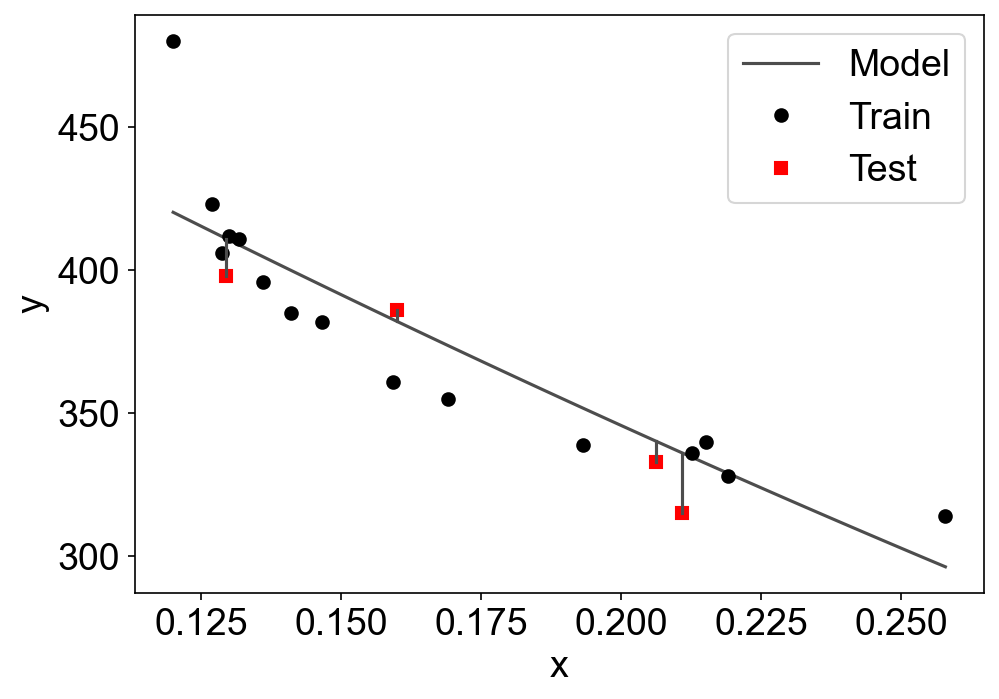

{'model': ElasticNet(),
 'rmse': 25.02531852609627,
 'rmse_std': 12.317017918591626,
 'baseline_rmse': 42.54946122739829,
 'baseline_rmse_std': 13.694390349187083,
 'corr': (-0.8769411874917533, -0.5812288664987114, -0.5304186200087936),
 'corr_std': (0.028429759667883758, 0.08068569908181904, 0.12185106756653163),
 'percent_error': 5.244552038299888,
 'percent_error_std': 2.1709569835195506,
 'percent_error_train': 4.4514011570488945,
 'percent_error_train_std': 0.4656297602449225,
 'r2_score': 0.18524711379733433,
 'r2_score_std': 1.2024225388716987,
 'r2_score_manual': 0.6540836439933803,
 'features': ('var_q_c20_c365_c3_ah',
  'var_q_c20_c56_c3_ah',
  'var_q_c20_c159_c3_ah')}

In [8]:
def train_and_test_model(df, xvars, yvar, 
                         to_plot=1, model=None, num_experiments=None,
                         log=False, square=False, sqrt=False):
    """
    Train and test a univariate linear regression model with cross-validation
    
    Args:
      df is a Pandas DataFrame object
      xvars is a list of strings (the feature names)
      yvar is a string (the label name)
      to_plot : make debug plots if true
      
    Returns:
      a dictionary holding model outputs
    """    
    # Fraction of samples reserved for model testing
    # e.g. 0.2 means 20% of samples reserved. In the 
    # context of cross-validation, this would be 
    # equivalent to a 5-fold cross-validation. The 
    # cross-validation we end up doing is not exactly
    # 5-fold cross-validation since we introduce random
    # sampling and many many repeats
    TEST_SIZE = 0.2
    
    # Number of trials
    num_experiments = num_experiments or 100
    
    # Unpack and filter data
    xvars = [xvars] if isinstance(xvars, str) else xvars
    # Create a temporary df to filter NaNs only from the columns we use
    xyvars = xvars + [yvar]
    df_nonans = df[xyvars].dropna()
    if log is True:
        df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))
    if square is True:
        df_nonans = df_nonans.apply(lambda x: x**2)
    if sqrt is True:
        df_nonans = df_nonans.apply(lambda x: np.sqrt(abs(x)))
    
    X = df_nonans[xvars].values
    y = df_nonans[yvar].values
        
    percent_error_list = []
    percent_error_train_list = []
    r2_score_list = []
    rmse_list = []
    baseline_rmse_list = []
    intercept_list = []
    coef_list = []
    corr_list = []
    
    has_plotted = 0
    
    for idx in range(num_experiments):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=TEST_SIZE)

        # apply standard scaler (fit only on train, transform both train and test)
        # keep originals for pltos
        X_train_original = X_train
        X_test_original = X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        (model, corr) = build_model(X_train, y_train, model)
        
        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)
        y_train_mean = np.mean(y_train)
        
        r2_score = model.score(X_test, y_test)
        
        if log is True:
            y_train = np.exp(y_train)
            y_pred_train = np.exp(y_pred_train)
            y_pred = np.exp(y_pred)
            y_test = np.exp(y_test)
            y_train_mean = np.exp(y_train_mean)
        if square is True:
            y_train = np.sqrt(y_train)
            y_pred_train = np.sqrt(y_pred_train)
            y_pred = np.sqrt(y_pred)
            y_test = np.sqrt(y_test)
            y_train_mean = np.sqrt(y_train_mean)
        if sqrt is True:
            y_train = (y_train)**2
            y_pred_train = (y_pred_train)**2
            y_pred = (y_pred)**2
            y_test = (y_test)**2
            y_train_mean = (y_train_mean)**2

        rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
        percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))
        percent_error_train = np.mean(np.abs(y_pred_train - y_train)/y_train) * 100
        
        rmse_list.append(rmse)
        percent_error_list.append(percent_error)
        percent_error_train_list.append(percent_error_train)
        r2_score_list.append(r2_score)
        baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
        corr_list.append(corr)
    
        # Give a visual into the cross-validation process
        if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
            has_plotted = 1
            
            x_fit = np.linspace(np.min(X), np.max(X), 100)
            x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
            y_fit = model.predict(x_fit_trans)
            if log is True:
                y_fit = np.exp(y_fit)
            if square is True:
                y_fit = np.sqrt(y_fit)
            if sqrt is True:
                y_fit = y_fit ** 2
            plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
            plt.plot(X_train_original, y_train, 'o', color='k')
            plt.plot(X_test_original, y_test, 's', color='r')
            
            for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
                plt.plot([this_x, this_x], 
                         [this_y, this_ypred], 
                         label='', color=(0.3, 0.3, 0.3))
                
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(['Model', 'Train', 'Test'])
            plt.show()
    
    # Package the output
    final_model = model
    # Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)
        
    final_rmse = np.mean(rmse_list)
    final_rmse_std = np.std(rmse_list)
    
    final_baseline_rmse = np.mean(baseline_rmse_list)
    final_baseline_rmse_std = np.std(baseline_rmse_list)
    
    # Column mean and column std of a list of tuples
    final_corr = tuple(map(np.mean, zip(*corr_list)))
    final_corr_std = tuple(map(np.std, zip(*corr_list)))
    
    final_percent_error = np.mean(percent_error_list)
    final_percent_error_std = np.std(percent_error_list)
    final_percent_error_train = np.mean(percent_error_train_list)
    final_percent_error_train_std = np.std(percent_error_train_list)
    
#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
    final_r2_score = np.mean(r2_score_list)
    final_r2_score_std = np.std(r2_score_list)
    
    model_output_dict = dict()
    model_output_dict['model'] = final_model
    model_output_dict['rmse'] = final_rmse
    model_output_dict['rmse_std'] = final_rmse_std
    model_output_dict['baseline_rmse'] = final_baseline_rmse
    model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
    model_output_dict['corr'] = final_corr
    model_output_dict['corr_std'] = final_corr_std
    model_output_dict['percent_error'] = final_percent_error
    model_output_dict['percent_error_std'] = final_percent_error_std
    model_output_dict['percent_error_train'] = final_percent_error_train
    model_output_dict['percent_error_train_std'] = final_percent_error_train_std
    model_output_dict['r2_score'] = final_r2_score
    model_output_dict['r2_score_std'] = final_r2_score_std
    model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
    model_output_dict['features'] = tuple(xvars)
    
    return model_output_dict

# Test
# one feature
# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      log=True)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      square=True)

train_and_test_model(df, 
                     "var_q_c20_c365_c3_ah", 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     sqrt=True)

# multiple features
train_and_test_model(df, 
                     ["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"], 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     model=ElasticNet())

# Single feature

## Set up and fit/predict/score

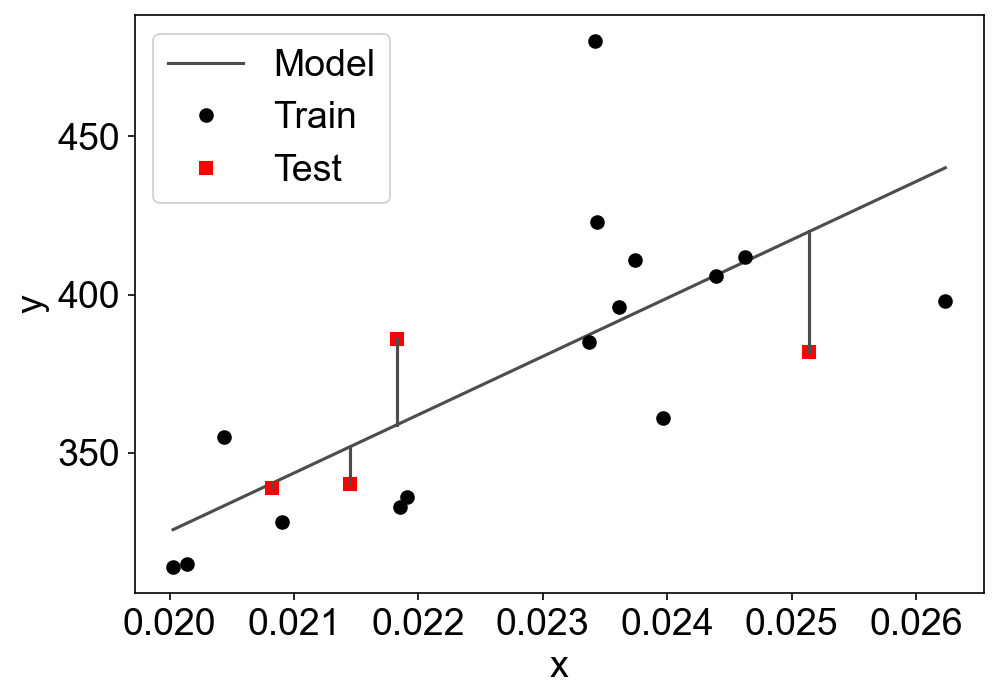

In [9]:
# Set the y-variable (the output the model is trying to predict)
yvar80 = 'cycles_to_80_pct'
yvar70 = 'cycles_to_70_pct'
yvar60 = 'cycles_to_60_pct'
yvar50 = 'cycles_to_50_pct'
yvar = yvar80

# Gather a list of modeled results. 
# Each element of the list holds all modeled results for a particular cycle
results_list = []

# First take care of the formation delta V signal, which only exists for the initial cycle
xvar = 'form_6hr_rest_delta_voltage_v'

model_output_dict = train_and_test_model(df, xvar, yvar)
model = model_output_dict['model']

results_dict = dict()
results_dict['cycle_index'] = 0 #
results_dict[xvar] = model_output_dict

results_list.append(results_dict)

Working on cycle 3...


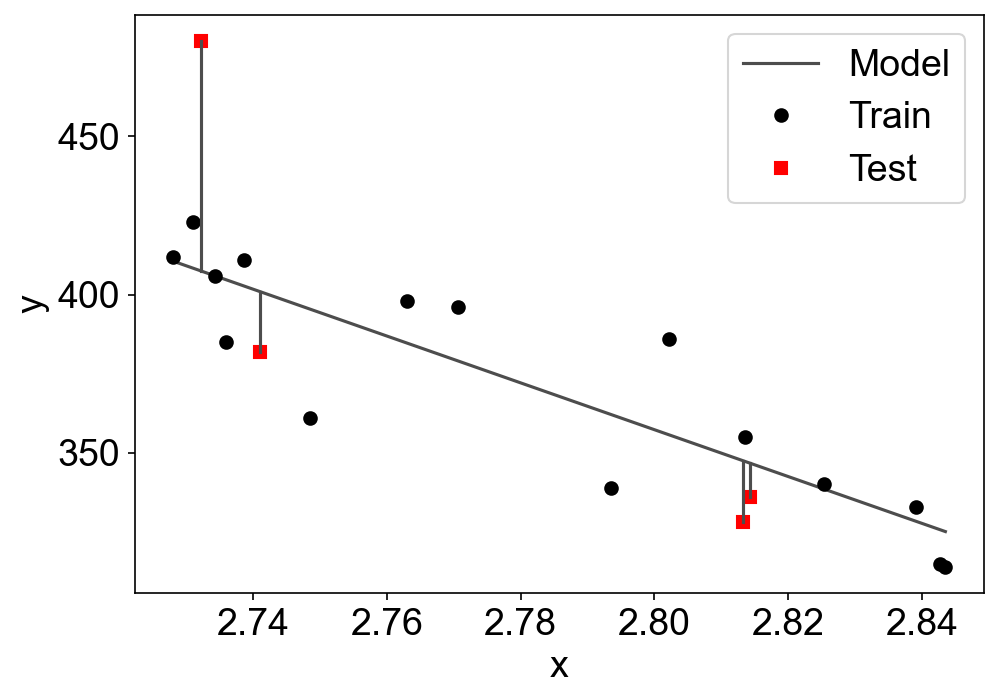

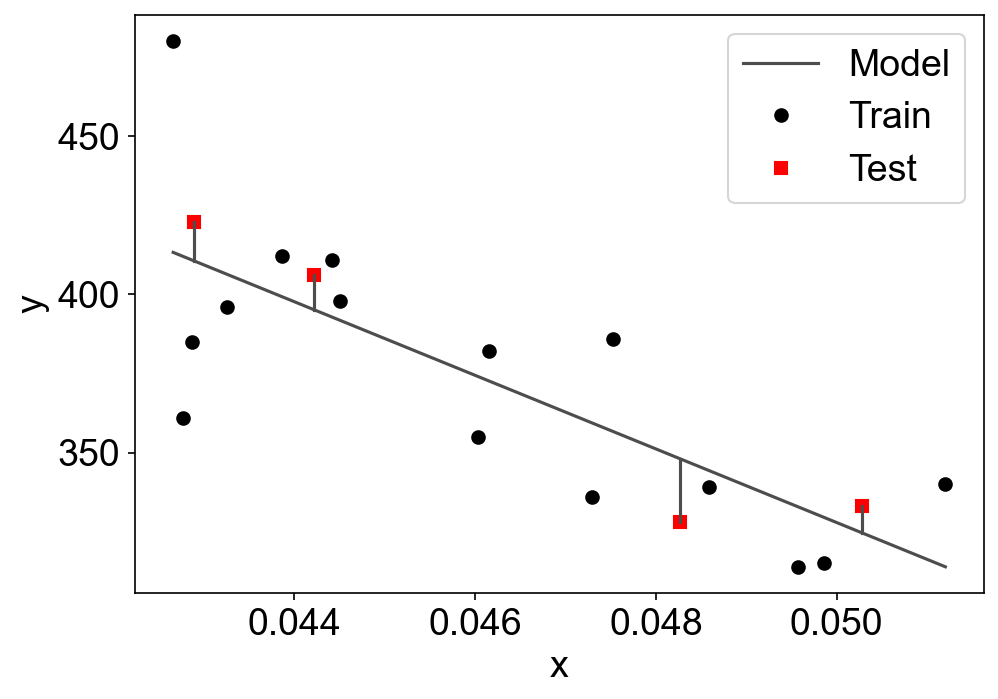

Working on cycle 56...


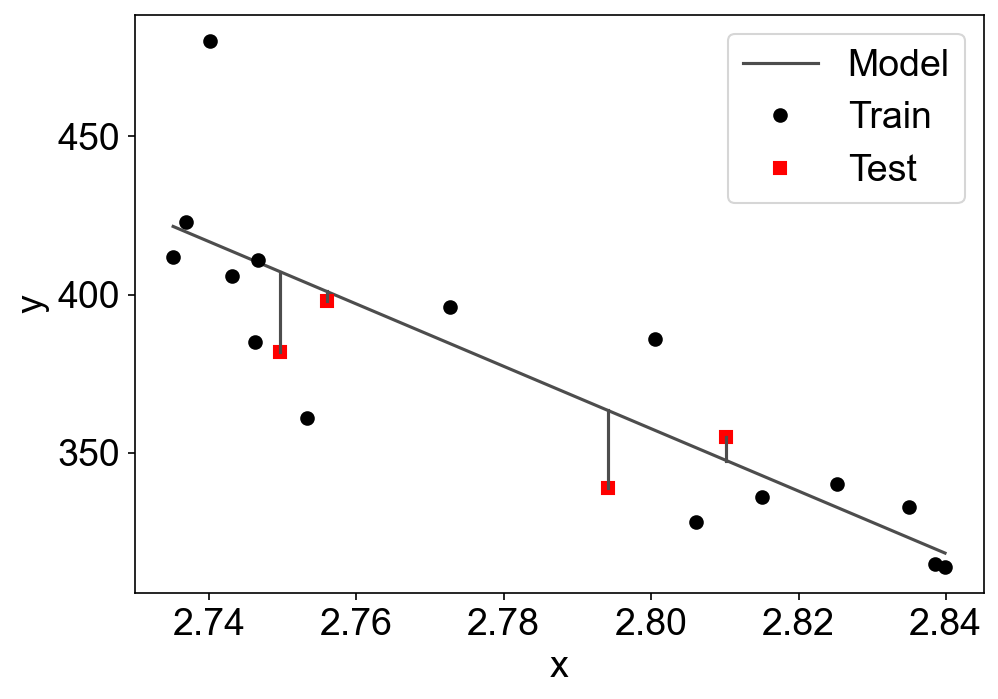

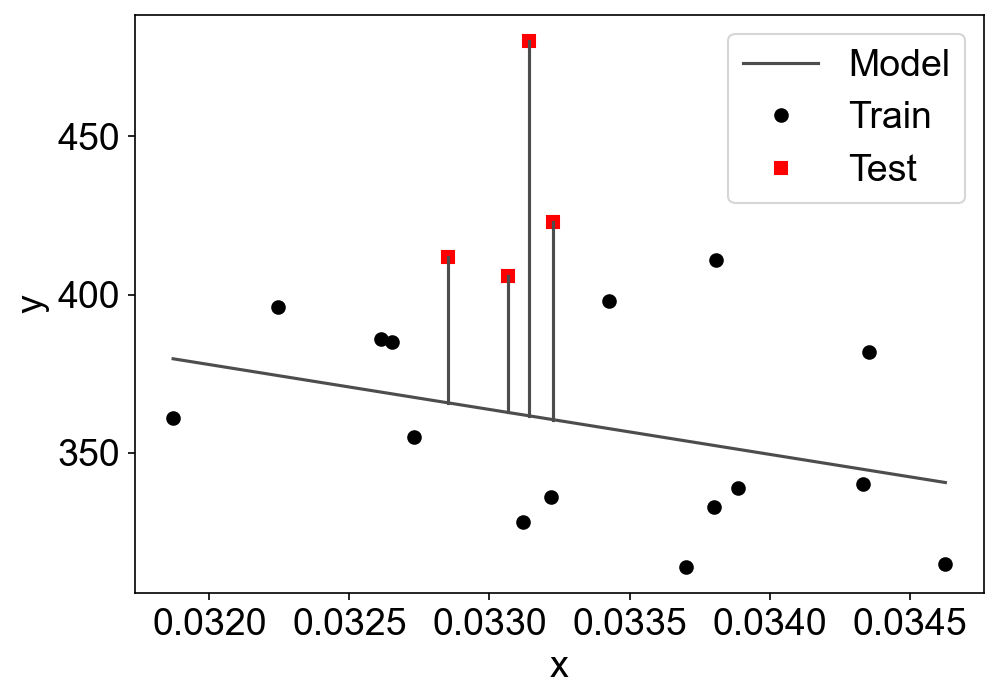

Working on cycle 159...


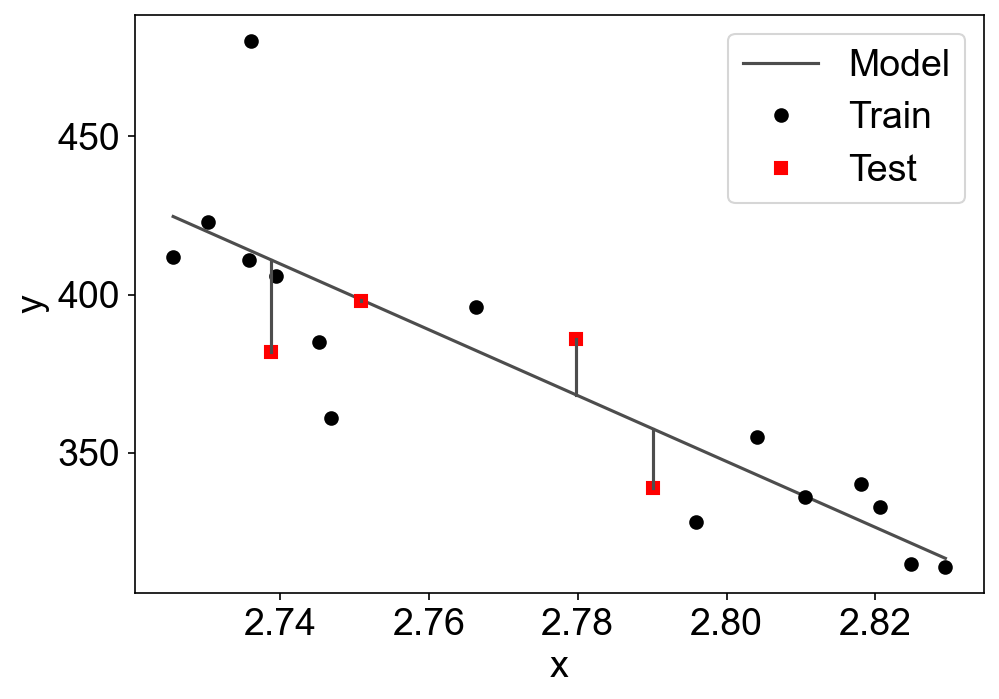

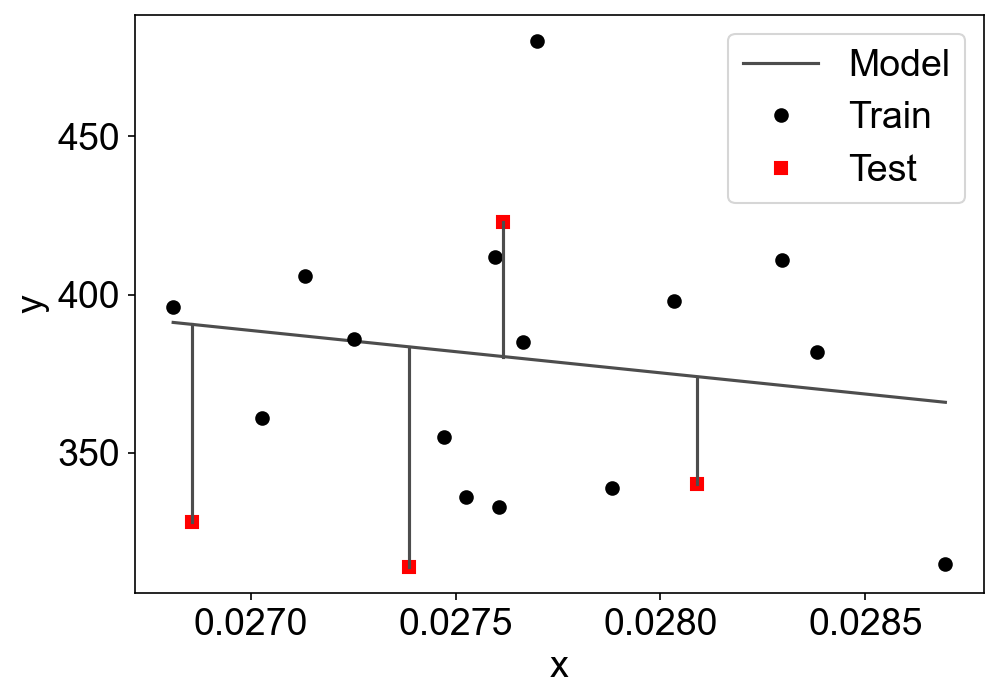

Working on cycle 262...


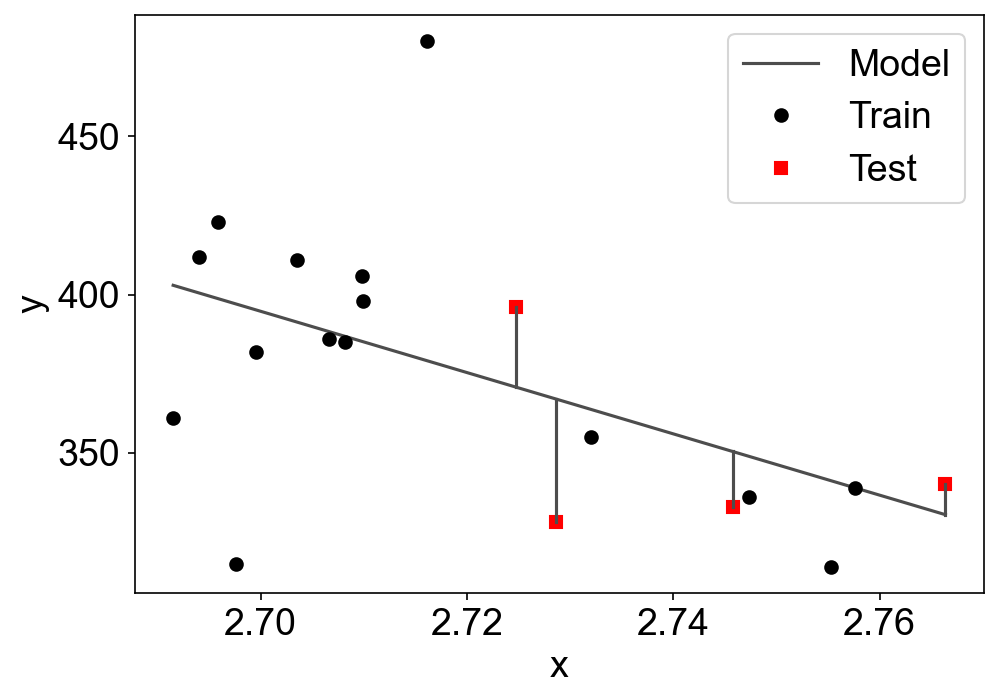

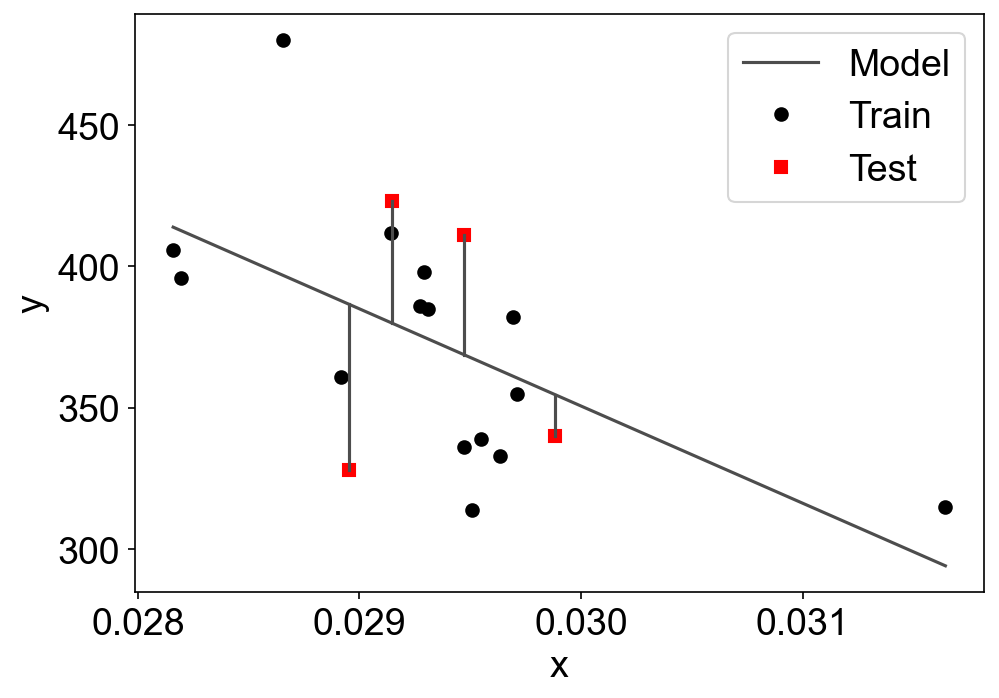

Working on cycle 365...


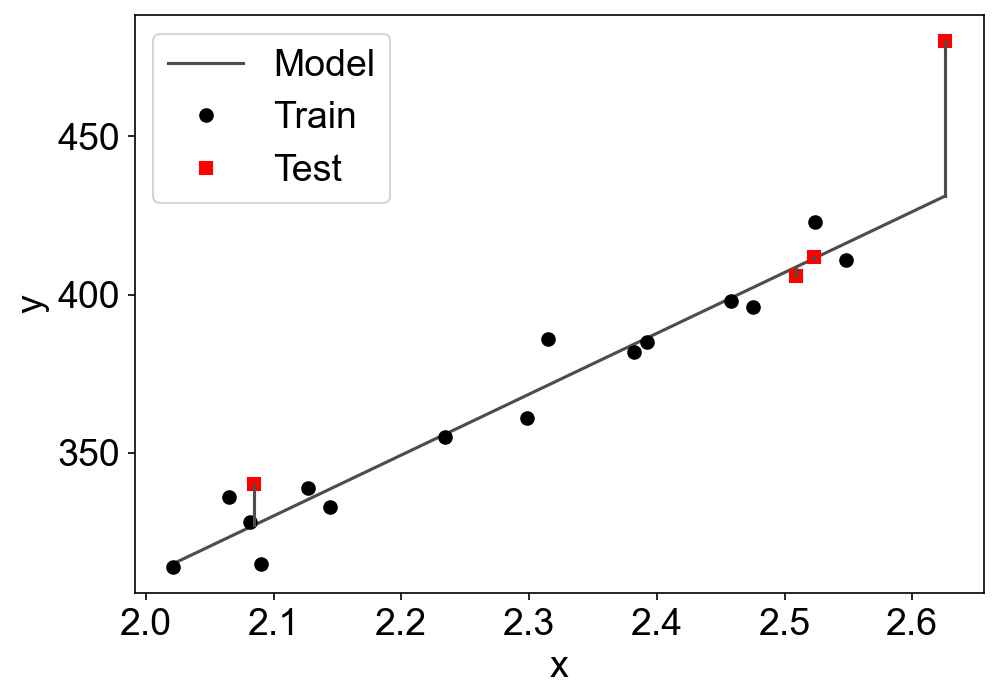

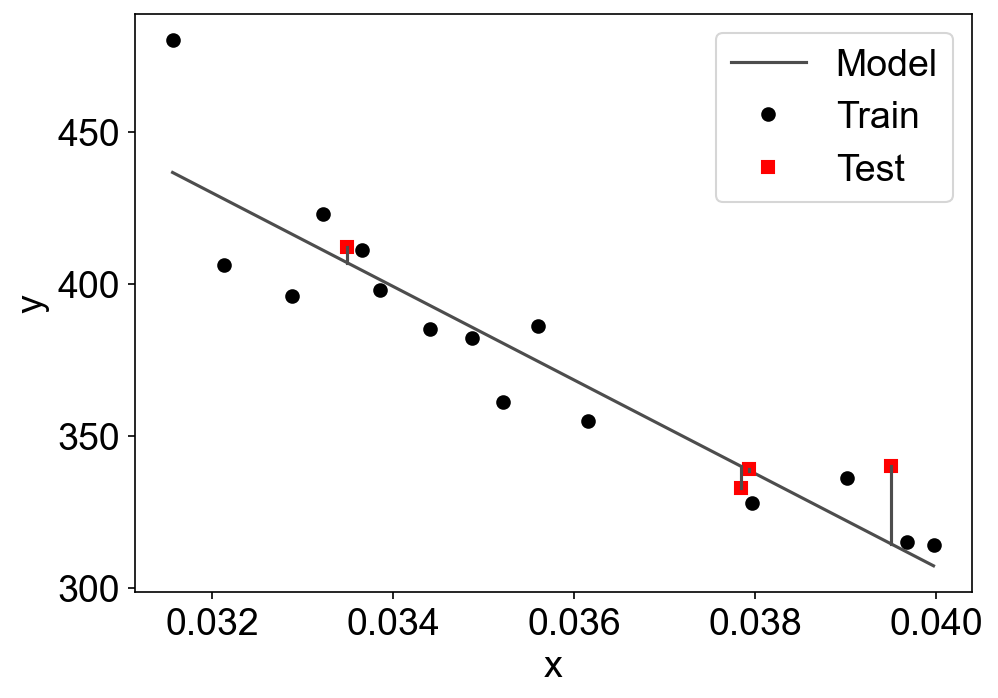

Done.


In [10]:
# Now take care of the rest of the signals. These signals exist for multiple cycles since 
# they exist at each RPT. So we will loop through the valid cycle indices and repeat this 
# process.

cycle_target_list = [3, 56, 159, 262, 365]

for cycle_idx in cycle_target_list:
    
    print(f'Working on cycle {cycle_idx}...')
    
    # Assemble x variables of interest
    xvar_array = [f'esoh_c{cycle_idx}_Cn',
                  f'dcr_10s_5_soc_at_c{cycle_idx}',
                  f'var_q_c{cycle_idx}_c3']
    
    results_dict = dict()
    results_dict['cycle_index'] = cycle_idx
    
    # Loop over x-variables
    for xvar in xvar_array:

        if not xvar in df.columns:
            continue
        
        model_output_dict = train_and_test_model(df, xvar, yvar)
        
        model = model_output_dict['model']

        if '_Cn' in xvar:
            xvar_label = 'Cn'
        if 'dcr_10s_5_soc' in xvar:
            xvar_label = 'dcr_10s_5_soc'
        if 'var_q' in xvar:
            xvar_label = 'var_q'
    
        results_dict[xvar_label] = model_output_dict
        
    results_list.append(results_dict)      
    
print('Done.')
    

Take a look at the results list variable.

It is a list of dictionaries. Each dictionary holds the output for a single cycle index.

In [11]:
results_list

[{'cycle_index': 0,
  'form_6hr_rest_delta_voltage_v': {'model': LinearRegression(),
   'rmse': 35.13813474394539,
   'rmse_std': 14.108039659316457,
   'baseline_rmse': 44.095891462280235,
   'baseline_rmse_std': 15.182733999591644,
   'corr': (0.7284689283990997,),
   'corr_std': (0.05970865122869467,),
   'percent_error': 7.188313775182476,
   'percent_error_std': 2.163378474403204,
   'percent_error_train': 5.588543270210681,
   'percent_error_train_std': 0.6006875513573275,
   'r2_score': -0.3485943105843041,
   'r2_score_std': 1.7854684138288297,
   'r2_score_manual': 0.36501838083078864,
   'features': ('form_6hr_rest_delta_voltage_v',)}},
 {'cycle_index': 3,
  'Cn': {'model': LinearRegression(),
   'rmse': 23.974450332571838,
   'rmse_std': 11.505254091008284,
   'baseline_rmse': 44.00503570149674,
   'baseline_rmse_std': 13.724950095800695,
   'corr': (-0.8498157494962328,),
   'corr_std': (0.033954627407118576,),
   'percent_error': 4.961407132233379,
   'percent_error_std': 

## Re-package the data to become easily plottable

Repackage the data to index by feature, which makes it easier for plotting.

There is probably a more "pandas-y" way to do this.

In [12]:
# Get a list of unique x-variable labels
unique_keys = set()
for result_dict in results_list:
    for key in result_dict.keys():
        unique_keys.add(key)
unique_keys.remove('cycle_index')

# Assemble the outputs into a dictionary
output_dict = dict()
for key in unique_keys:
    
    cycle_list = []
    rmse_list = []
    rmse_std_list = []
    corr_list = []
    corr_std_list = []
    percent_error_list = []
    percent_error_std_list = []
    
    for result_dict in results_list:

        cycle_list.append(result_dict['cycle_index'])    
        
        if not key in result_dict:
            rmse_list.append(np.nan)
            rmse_std_list.append(np.nan)
            corr_list.append(np.nan)
            corr_std_list.append(np.nan)
            percent_error_list.append(np.nan)
            percent_error_std_list.append(np.nan)
            continue

        rmse_list.append(result_dict[key]['rmse'])
        rmse_std_list.append(result_dict[key]['rmse_std'])
        if len(result_dict[key]['corr']) == 1:
            corr_list.append(result_dict[key]['corr'][0])
            corr_std_list.append(result_dict[key]['corr_std'][0])
        percent_error_list.append(result_dict[key]['percent_error'])
        percent_error_std_list.append(result_dict[key]['percent_error_std'])
        
        
    this_result = dict()
    this_result['cycle_index'] = cycle_list
    this_result['rmse'] = rmse_list
    this_result['rmse_std'] = rmse_std_list
    this_result['corr'] = corr_list
    this_result['corr_std'] = corr_std_list
    this_result['percent_error'] = percent_error_list
    this_result['percent_error_std'] = percent_error_std_list
    
    output_dict[key] = this_result
    
# The output dictionary is now indexed by feature
output_dict

{'form_6hr_rest_delta_voltage_v': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [35.13813474394539, nan, nan, nan, nan, nan],
  'rmse_std': [14.108039659316457, nan, nan, nan, nan, nan],
  'corr': [0.7284689283990997, nan, nan, nan, nan, nan],
  'corr_std': [0.05970865122869467, nan, nan, nan, nan, nan],
  'percent_error': [7.188313775182476, nan, nan, nan, nan, nan],
  'percent_error_std': [2.163378474403204, nan, nan, nan, nan, nan]},
 'dcr_10s_5_soc': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   25.943548682634535,
   43.81332862179641,
   46.339712609145536,
   38.15053294161486,
   17.12162452039497],
  'rmse_std': [nan,
   10.792120237294718,
   12.950898130613893,
   13.568735708401128,
   12.0690520392612,
   7.4110371640555295],
  'corr': [nan,
   -0.8067060985199991,
   -0.3415124663735433,
   -0.03580226878797591,
   -0.5613595336686962,
   -0.9327029256176518],
  'corr_std': [nan,
   0.038570786465968405,
   0.07798831829468171,
   0.1355250866532205

## Visualize the results

In [13]:
# Create another dictionary of labels
label_dict = dict()
label_dict['var_q'] = '$\Delta Q$'
label_dict['Cn'] = '$C_n$'
label_dict['dcr_10s_5_soc'] = '$R_{10s, 5\%SOC}$'
label_dict['form_6hr_rest_delta_voltage_v'] = '$\Delta V_{rest, 6hr}$'

# Multiple features from formation

## Data analysis

In [14]:
yvar = yvar70

Select relevant formation features

In [15]:
form_select = lambda x: x.startswith("form_") and "trace" not in x and "rebound" not in x
form_features = list(filter(form_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_form = df[form_features + labels]
df_form.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 33 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah  19 non-null     float64
 1   form_last_charge_voltage_after_1s            19 non-null     float64
 2   form_last_charge_voltage_after_10s           19 non-null     float64
 3   form_last_charge_voltage_after_60s           19 non-null     float64
 4   form_first_charge_capacity_ah                19 non-null     float64
 5   form_first_discharge_capacity_ah             19 non-null     float64
 6   form_first_cycle_efficiency                  19 non-null     float64
 7   form_final_discharge_capacity_ah             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr      19 non-null     float64
 9   form_6hr_rest_delta_voltage_v_0_to_2_hr      19 non-null     float64
 10  form

In [16]:
df_form_sq = df_form.apply(lambda x: x**2).rename(lambda s: s + "_squared", axis="columns")
df_form_sq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 33 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah_squared  19 non-null     float64
 1   form_last_charge_voltage_after_1s_squared            19 non-null     float64
 2   form_last_charge_voltage_after_10s_squared           19 non-null     float64
 3   form_last_charge_voltage_after_60s_squared           19 non-null     float64
 4   form_first_charge_capacity_ah_squared                19 non-null     float64
 5   form_first_discharge_capacity_ah_squared             19 non-null     float64
 6   form_first_cycle_efficiency_squared                  19 non-null     float64
 7   form_final_discharge_capacity_ah_squared             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr_squared      19 non-null     flo

In [17]:
df_form_plus_sq = pd.concat([df_form, df_form_sq], axis=1)
df_form_plus_sq.head()

,form_first_discharge_capacity_below_3p2v_ah,form_last_charge_voltage_after_1s,form_last_charge_voltage_after_10s,form_last_charge_voltage_after_60s,form_first_charge_capacity_ah,form_first_discharge_capacity_ah,form_first_cycle_efficiency,form_final_discharge_capacity_ah,form_6hr_rest_delta_voltage_v_0_to_1_hr,form_6hr_rest_delta_voltage_v_0_to_2_hr,form_6hr_rest_delta_voltage_v_0_to_3_hr,form_6hr_rest_delta_voltage_v_0_to_4_hr,form_6hr_rest_delta_voltage_v_0_to_5_hr,form_6hr_rest_delta_voltage_v_0_to_6_hr,form_6hr_rest_delta_voltage_v_1_to_6_hr,form_6hr_rest_delta_voltage_v_2_to_6_hr,form_6hr_rest_delta_voltage_v_3_to_6_hr,form_6hr_rest_delta_voltage_v_4_to_6_hr,form_6hr_rest_delta_voltage_v_5_to_6_hr,form_c20_charge_qpp_ah,form_c20_charge_right_peak_v_per_ah,form_6hr_rest_delta_voltage_v,form_6hr_rest_voltage_v,form_6hr_rest_mv_per_day_steady,form_6hr_rest_mv_per_sec_initial,form_first_cv_hold_capacity_ah,form_coulombic_efficiency,form_qc_minus_qd_ah,form_total_lithium_consumed,cycles_to_50_pct,cycles_to_60_pct,cycles_to_70_pct,cycles_to_80_pct,form_first_discharge_capacity_below_3p2v_ah_squared,form_last_charge_voltage_after_1s_squared,form_last_charge_voltage_after_10s_squared,form_last_charge_voltage_after_60s_squared,form_first_charge_capacity_ah_squared,form_first_discharge_capacity_ah_squared,form_first_cycle_efficiency_squared,form_final_discharge_capacity_ah_squared,form_6hr_rest_delta_voltage_v_0_to_1_hr_squared,form_6hr_rest_delta_voltage_v_0_to_2_hr_squared,form_6hr_rest_delta_voltage_v_0_to_3_hr_squared,form_6hr_rest_delta_voltage_v_0_to_4_hr_squared,form_6hr_rest_delta_voltage_v_0_to_5_hr_squared,form_6hr_rest_delta_voltage_v_0_to_6_hr_squared,form_6hr_rest_delta_voltage_v_1_to_6_hr_squared,form_6hr_rest_delta_voltage_v_2_to_6_hr_squared,form_6hr_rest_delta_voltage_v_3_to_6_hr_squared,form_6hr_rest_delta_voltage_v_4_to_6_hr_squared,form_6hr_rest_delta_voltage_v_5_to_6_hr_squared,form_c20_charge_qpp_ah_squared,form_c20_charge_right_peak_v_per_ah_squared,form_6hr_rest_delta_voltage_v_squared,form_6hr_rest_voltage_v_squared,form_6hr_rest_mv_per_day_steady_squared,form_6hr_rest_mv_per_sec_initial_squared,form_first_cv_hold_capacity_ah_squared,form_coulombic_efficiency_squared,form_qc_minus_qd_ah_squared,form_total_lithium_consumed_squared,cycles_to_50_pct_squared,cycles_to_60_pct_squared,cycles_to_70_pct_squared,cycles_to_80_pct_squared
0,0.077820,3.393505,3.403936,3.420587,2.755302,2.312734,0.839376,2.367225,0.011104,0.014412,0.016395,0.017794,0.018984,0.019909,0.008731,0.005468,0.003486,0.002091,0.000912,0.837702,0.357891,0.020902,4.179098,-25.052050,-0.006106,0.163624,0.859153,0.388076,0.388076,400,391,373,328,0.006056,11.515874,11.586781,11.700416,7.591687,5.348737,0.704552,5.603755,0.000123,0.000208,0.000269,0.000317,0.000360,0.000396,0.000076,0.000030,0.000012,0.000004,8.308546e-07,0.701745,0.128086,0.000437,17.464862,627.605221,0.000037,0.026773,0.738144,0.150603,0.150603,160000,152881,139129,107584
1,0.073791,3.401924,3.412256,3.428007,2.698299,2.313851,0.857522,2.363418,0.010694,0.013741,0.015612,0.017002,0.018085,0.018962,0.008188,0.005158,0.003323,0.001943,0.000871,0.841618,0.370042,0.020029,4.179971,-22.342436,-0.005931,0.137551,0.875892,0.334881,0.334881,401,368,338,314,0.005445,11.573087,11.643490,11.751229,7.280819,5.353905,0.735344,5.585745,0.000114,0.000189,0.000244,0.000289,0.000327,0.000360,0.000067,0.000027,0.000011,0.000004,7.582824e-07,0.708321,0.136931,0.000401,17.472156,499.184462,0.000035,0.018920,0.767186,0.112145,0.112145,160801,135424,114244,98596
2,0.074725,3.398755,3.409052,3.424840,2.713403,2.309945,0.851309,2.362668,0.011531,0.015044,0.017074,0.018645,0.019790,0.020716,0.009108,0.005626,0.003614,0.002052,0.000918,0.834678,0.363489,0.021827,4.178173,-25.481863,-0.006240,0.153544,0.870740,0.350734,0.350734,520,498,455,386,0.005584,11.551533,11.621637,11.729527,7.362553,5.335845,0.724728,5.582202,0.000133,0.000226,0.000292,0.000348,0.000392,0.000429,0.000083,0.000032,0.000013,0.000004,8

Look for correlations

In [18]:
df_form.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct                               1.000000
cycles_to_60_pct                               0.995579
cycles_to_70_pct                               0.976940
cycles_to_80_pct                               0.971337
form_last_charge_voltage_after_60s             0.802370
form_c20_charge_right_peak_v_per_ah            0.772470
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.730636
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.729484
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.726760
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.721277
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.711559
form_6hr_rest_delta_voltage_v                  0.710422
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.698247
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.651170
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.565207
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.505149
form_6hr_rest_delta_voltage_v_4_to_6_hr        0.467371
form_6hr_rest_delta_voltage_v_5_to_6_hr        0

Select and plot features with abs(corr) > 0.6

In [19]:
high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.6
high_corr_form_features = list(filter(high_corr, form_features))
high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_10s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_6hr_rest_delta_voltage_v_0_to_1_hr',
 'form_6hr_rest_delta_voltage_v_0_to_2_hr',
 'form_6hr_rest_delta_voltage_v_0_to_3_hr',
 'form_6hr_rest_delta_voltage_v_0_to_4_hr',
 'form_6hr_rest_delta_voltage_v_0_to_5_hr',
 'form_6hr_rest_delta_voltage_v_0_to_6_hr',
 'form_6hr_rest_delta_voltage_v_1_to_6_hr',
 'form_c20_charge_right_peak_v_per_ah',
 'form_6hr_rest_delta_voltage_v',
 'form_6hr_rest_voltage_v',
 'form_6hr_rest_mv_per_sec_initial']

In [20]:
very_high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.77
very_high_corr_form_features = list(filter(very_high_corr, form_features))
very_high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_c20_charge_right_peak_v_per_ah']

In [21]:
df_form[high_corr_form_features].corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
form_6hr_rest_mv_per_sec_initial               0.871221
form_6hr_rest_voltage_v                        0.890137
form_last_charge_voltage_after_10s             0.937693
form_first_discharge_capacity_below_3p2v_ah    0.994841
form_last_charge_voltage_after_1s              0.998766
form_first_cycle_efficiency                    0.999884
form_first_discharge_capacity_ah               1.000000
Name: form_first_discharge_capacity_ah, dtype: f

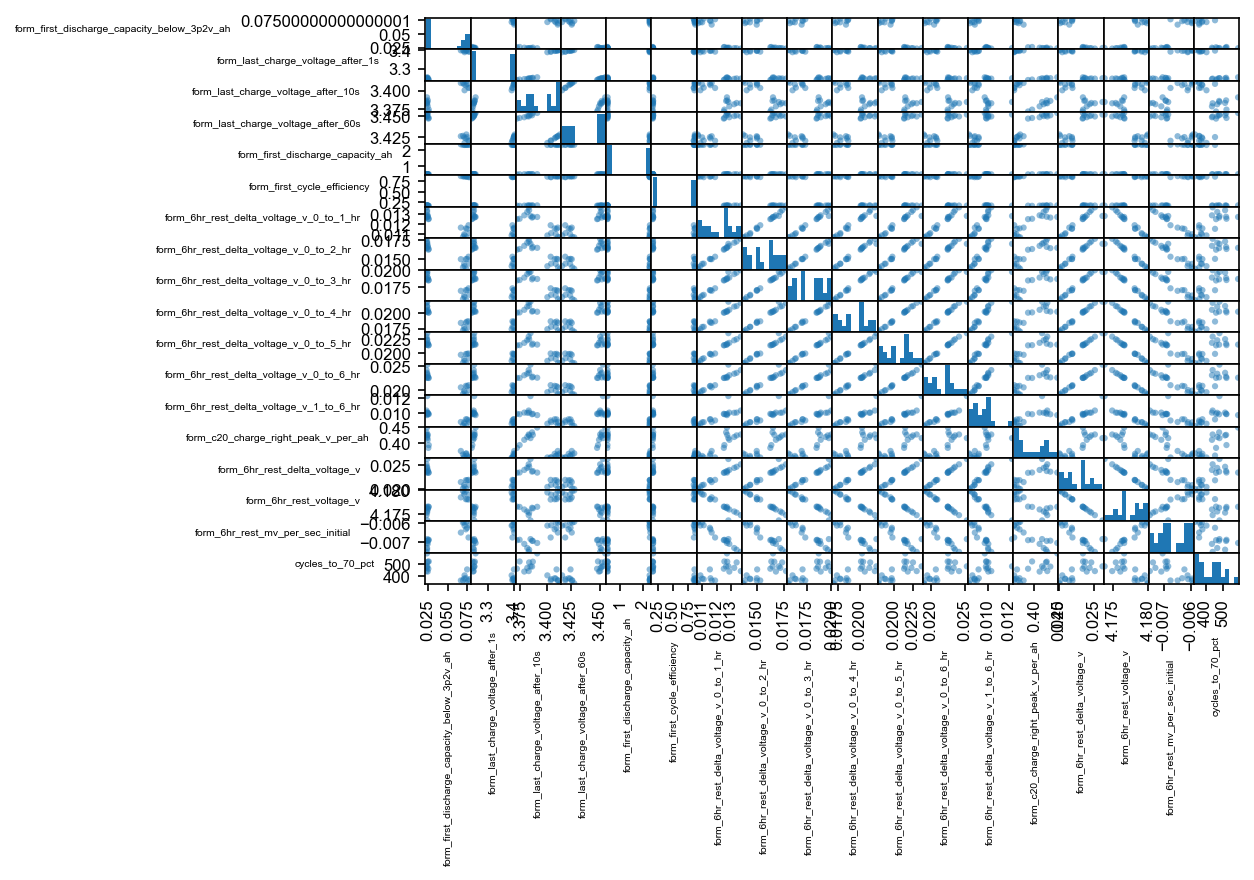

In [22]:
from pandas.plotting import scatter_matrix
plt.rcParams['axes.labelsize'] = 5
axes = scatter_matrix(df_form[high_corr_form_features + [yvar]])

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
OUTPUT_DIR = "notebooks/imgs/"
plt.tight_layout()
plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")

In [23]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
config_plots()

### with log

In [24]:
df_form_log = df_form.apply(lambda x: np.log(abs(x)))
df_form_log.describe()

,form_first_discharge_capacity_below_3p2v_ah,form_last_charge_voltage_after_1s,form_last_charge_voltage_after_10s,form_last_charge_voltage_after_60s,form_first_charge_capacity_ah,form_first_discharge_capacity_ah,form_first_cycle_efficiency,form_final_discharge_capacity_ah,form_6hr_rest_delta_voltage_v_0_to_1_hr,form_6hr_rest_delta_voltage_v_0_to_2_hr,form_6hr_rest_delta_voltage_v_0_to_3_hr,form_6hr_rest_delta_voltage_v_0_to_4_hr,form_6hr_rest_delta_voltage_v_0_to_5_hr,form_6hr_rest_delta_voltage_v_0_to_6_hr,form_6hr_rest_delta_voltage_v_1_to_6_hr,form_6hr_rest_delta_voltage_v_2_to_6_hr,form_6hr_rest_delta_voltage_v_3_to_6_hr,form_6hr_rest_delta_voltage_v_4_to_6_hr,form_6hr_rest_delta_voltage_v_5_to_6_hr,form_c20_charge_qpp_ah,form_c20_charge_right_peak_v_per_ah,form_6hr_rest_delta_voltage_v,form_6hr_rest_voltage_v,form_6hr_rest_mv_per_day_steady,form_6hr_rest_mv_per_sec_initial,form_first_cv_hold_capacity_ah,form_coulombic_efficiency,form_qc_minus_qd_ah,form_total_lithium_consumed,cycles_to_50_pct,cycles_to_60_pct,cycles_to_70_pct,cycles_to_80_pct
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,-3.198979,1.198703,1.222002,1.234841,1.003142,0.008368,-0.994774,0.860630,-4.416723,-4.154705,-4.027465,-3.944998,-3.883855,-3.834568,-4.662539,-5.138434,-5.584912,-6.106247,-6.889485,-0.193719,-0.936777,-3.788369,1.429665,3.283506,-5.013654,-1.833580,-0.142512,-1.020038,-1.020038,6.157029,6.129393,6.071392,5.917141
std,0.564067,0.023588,0.004068,0.004154,0.012057,0.812216,0.816364,0.004333,0.078911,0.081232,0.081521,0.081520,0.082560,0.083913,0.097459,0.104120,0.111652,0.125078,0.139269,0.012409,0.077617,0.079906,0.000434,0.122411,0.076793,0.191036,0.014094,0.100625,0.100625,0.137870,0.141898,0.157375,0.114463
min,-3.766923,1.174555,1.215440,1.228971,0.988929,-0.759595,-1.784166,0.854034,-4.538118,-4.287379,-4.159709,-4.074441,-4.012656,-3.965303,-4.805102,-5.273309,-5.714860,-6.296313,-7.082406,-0.212344,-1.028343,-3.910563,1.428819,3.089908,-5.127538,-2.107536,-0.177767,-1.192393,-1.192393,5.963579,5.908083,5.823046,5.749393
25%,-3.729466,1.177094,1.218782,1.231004,0.994866,-0.741329,-1.746586,0.858194,-4.481583,-4.219624,-4.093161,-4.011438,-3.947743,-3.902634,-4.739833,-5.212468,-5.663759,-6.193173,-6.977784,-0.201914,-1.007635,-3.854876,1.429388,3.229461,-5.086119,-1.950979,-0.148859,-1.094166,-1.094166,6.029447,6.003860,5.928236,5.821556
50%,-3.649625,1.179177,1.221083,1.237599,0.998291,-0.728661,-1.722820,0.860109,-4.382669,-4.119745,-3.990245,-3.907843,-3.846605,-3.796788,-4.635639,-5.124034,-5.583466,-6.104196,-6.894271,-0.197210,-0.950373,-3.756125,1.429504,3.287517,-4.986180,-1.833455,-0.140830,-1.032166,-1.032166,6.167516,6.142037,6.089045,5.945421
75%,-2.626924,1.223027,1.226052,1.238623,1.009378,0.838672,-0.157774,0.862090,-4.360943,-4.093166,-3.969338,-3.889434,-3.828549,-3.778612,-4.610155,-5.095315,-5.554262,-6.065590,-6.848073,-0.185107,-0.863439,-3.735742,1.430029,3.316668,-4.964233,-1.751070,-0.132378,-0.969905,-0.969905,6.269913,6.234134,6.173784,5.996403
max,-2.553354,1.224341,1.227374,1.239590,1.037936,0.850454,-0.140043,0.869140,-4.293166,-4.035049,-3.912592,-3.822837,-3.746646,-3.679543,-4.395505,-4.808976,-5.212010,-5.701474,-6.432656,-0.172429,-0.803515,-3.640673,1.430304,3.686194,-4.892418,-1.422342,-0.119789,-0.776915,-0.776915,6.416732,6.400257,6.380123,6.173786


In [25]:
df_form_log.corr()[yvar].sort_values(ascending=False)

cycles_to_70_pct                               1.000000
cycles_to_60_pct                               0.983852
cycles_to_80_pct                               0.978925
cycles_to_50_pct                               0.973508
form_last_charge_voltage_after_60s             0.834031
form_c20_charge_right_peak_v_per_ah            0.808079
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.775806
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.770741
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.770716
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.764190
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.751677
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.749858
form_6hr_rest_delta_voltage_v                  0.747567
form_6hr_rest_mv_per_sec_initial               0.707107
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.689184
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.604837
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.541764
form_6hr_rest_delta_voltage_v_4_to_6_hr        0

## Training a regularized model

### Individual features

In [26]:
from sklearn.dummy import DummyRegressor

In [27]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
# train_and_test_model(df, form_features, yvar, to_plot=0, model=Ridge())
# model = ElasticNet(0.01, l1_ratio=0.5)
# train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
# print(model.coef_)

form_first_discharge_capacity_below_3p2v_ah       7.75 (2.45 std)
form_last_charge_voltage_after_1s                 7.56 (2.35 std)
form_last_charge_voltage_after_10s                8.64 (2.74 std)
form_last_charge_voltage_after_60s                7.77 (2.71 std)
form_first_charge_capacity_ah                     14.09 (3.93 std)
form_first_discharge_capacity_ah                  7.34 (2.51 std)
form_first_cycle_efficiency                       7.43 (2.35 std)
form_final_discharge_capacity_ah                  13.22 (4.35 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           9.27 (3.20 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           8.88 (2.97 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           8.60 (2.89 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           8.99 (2.80 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           9.16 (2.75 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           9.36 (2.82 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           11.48 (4.03 std)
form_6h

with log

In [28]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000, log=True)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000, log=True)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")


form_first_discharge_capacity_below_3p2v_ah       7.63 (2.44 std)
form_last_charge_voltage_after_1s                 7.30 (2.48 std)
form_last_charge_voltage_after_10s                8.48 (2.93 std)
form_last_charge_voltage_after_60s                7.39 (2.63 std)
form_first_charge_capacity_ah                     14.00 (3.80 std)
form_first_discharge_capacity_ah                  7.25 (2.52 std)
form_first_cycle_efficiency                       7.37 (2.50 std)
form_final_discharge_capacity_ah                  13.12 (4.22 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           9.12 (3.16 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           8.51 (2.98 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           8.51 (2.90 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           8.97 (2.76 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           8.94 (2.74 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           9.37 (2.87 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           10.96 (4.37 std)
form_6h

### Manual hyperparameter loops

In [29]:
def manual_gridsearch(features, yvar, log=False):
    gridsearch = {}
    def ridge(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Ridge(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Ridge"] = (alphas, list(map(ridge, alphas)))
    
    def lasso(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Lasso(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Lasso"] = (alphas, list(map(lasso, alphas)))
    
    def elastic_net(alpha, l1_ratio):
        return train_and_test_model(df, features, yvar, to_plot=0, 
                                    model=ElasticNet(alpha, l1_ratio=l1_ratio), log=log)["percent_error"]

    N = 10
    alphas = np.logspace(0,2,N)
    l1_ratios = np.linspace(0,1,N)
    errors = np.empty((N,N))
    for i, alpha in enumerate(alphas):
        print(i)
        for j, l1_ratio in enumerate(l1_ratios):
            errors[i,j] = elastic_net(alpha, l1_ratio)
    gridsearch["ElasticNet"] = (alphas, l1_ratios, errors)
    
    return gridsearch

In [30]:
gridsearch = manual_gridsearch(form_features, yvar70)

0
1
2
3
4
5
6
7
8
9


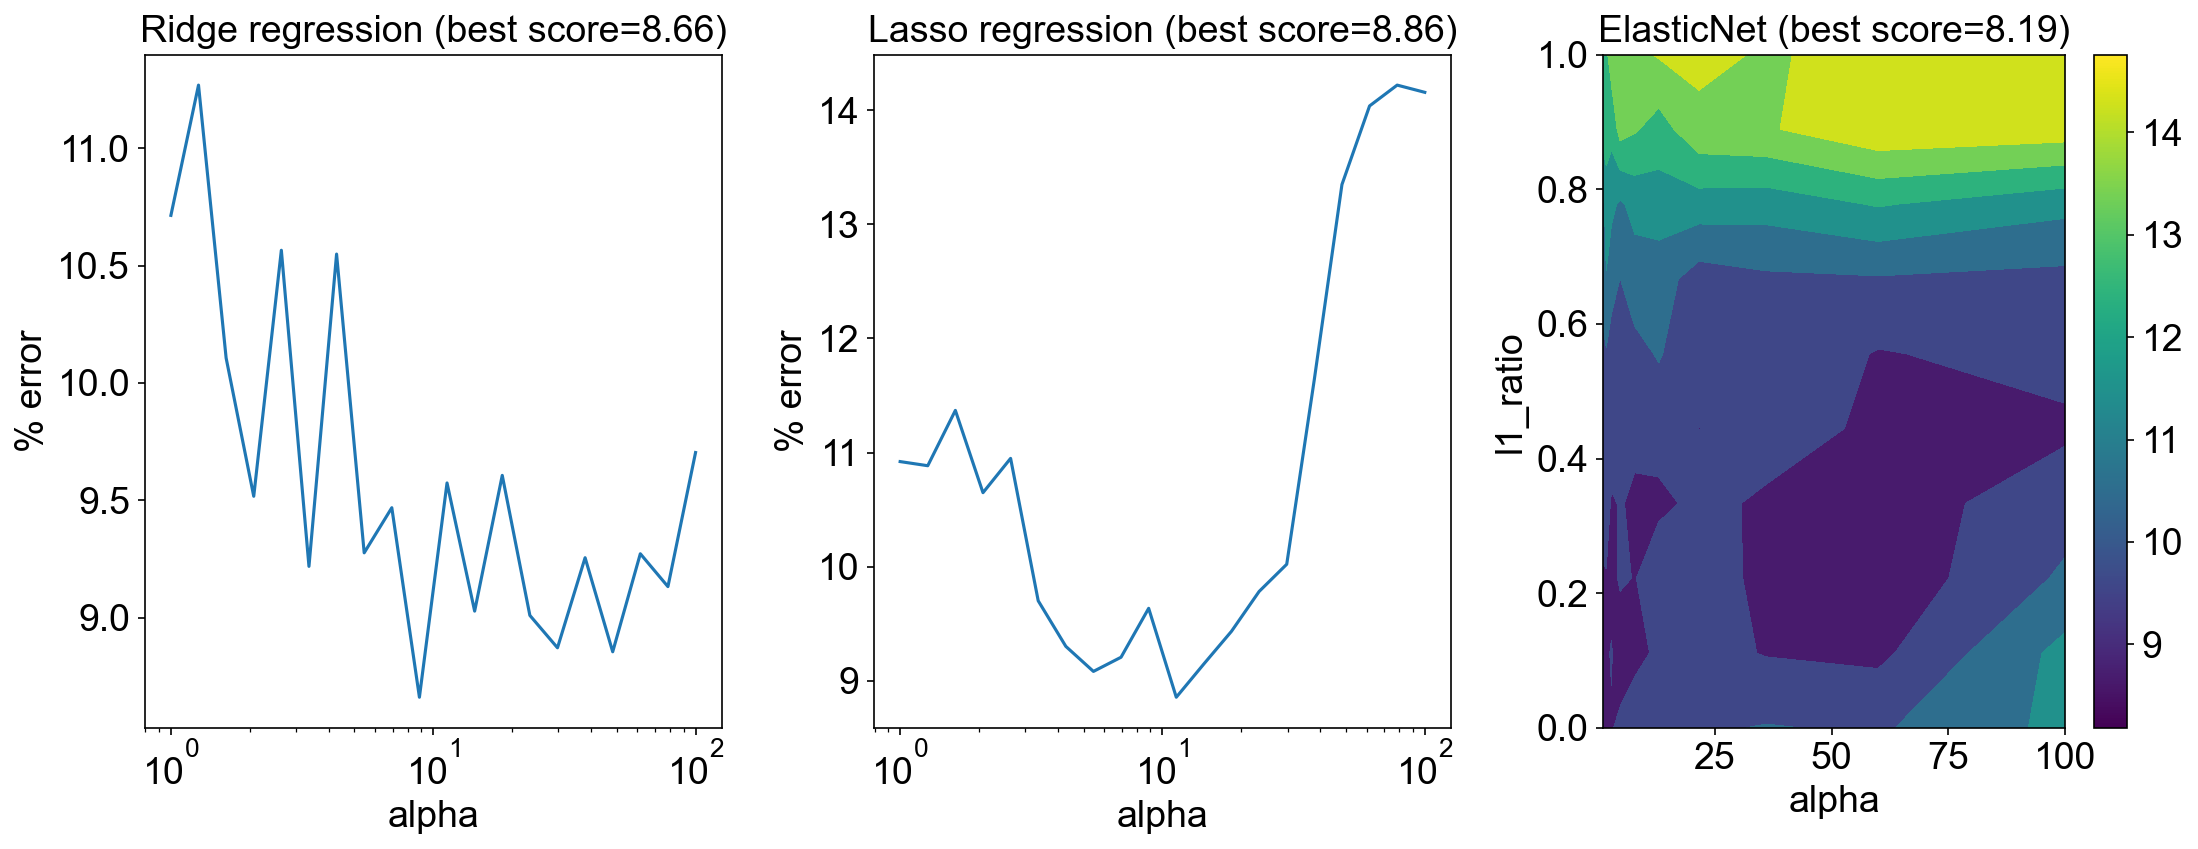

In [31]:
def plot_gridsearch(gridsearch):
    fig, axes = plt.subplots(1,3,figsize=(15,6))

    ax = axes[0]
    ax.semilogx(*gridsearch["Ridge"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Ridge regression (best score={np.min(gridsearch['Ridge'][1]):.2f})")

    ax = axes[1]
    ax.semilogx(*gridsearch["Lasso"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Lasso regression (best score={np.min(gridsearch['Lasso'][1]):.2f})")

    ax = axes[2]
    ax.contourf(*gridsearch["ElasticNet"])
    ax.set_title(f"ElasticNet (best score={np.min(gridsearch['ElasticNet'][2]):.2f})")
    ax.set_xlabel("alpha")
    ax.set_ylabel("l1_ratio")
    vmin = np.min(gridsearch['ElasticNet'][2])
    vmax = np.max(gridsearch['ElasticNet'][2])
    plt.colorbar(cm.ScalarMappable(colors.Normalize(vmin=vmin, vmax=vmax)), ax=ax)

    fig.tight_layout()
    return fig

fig = plot_gridsearch(gridsearch)
fig.savefig(OUTPUT_DIR + "manual_gridsearch.pdf")

### Manual, high corr features

In [32]:
gridsearch_highcorr = manual_gridsearch(high_corr_form_features, yvar70)

0
1
2
3
4
5
6
7
8
9


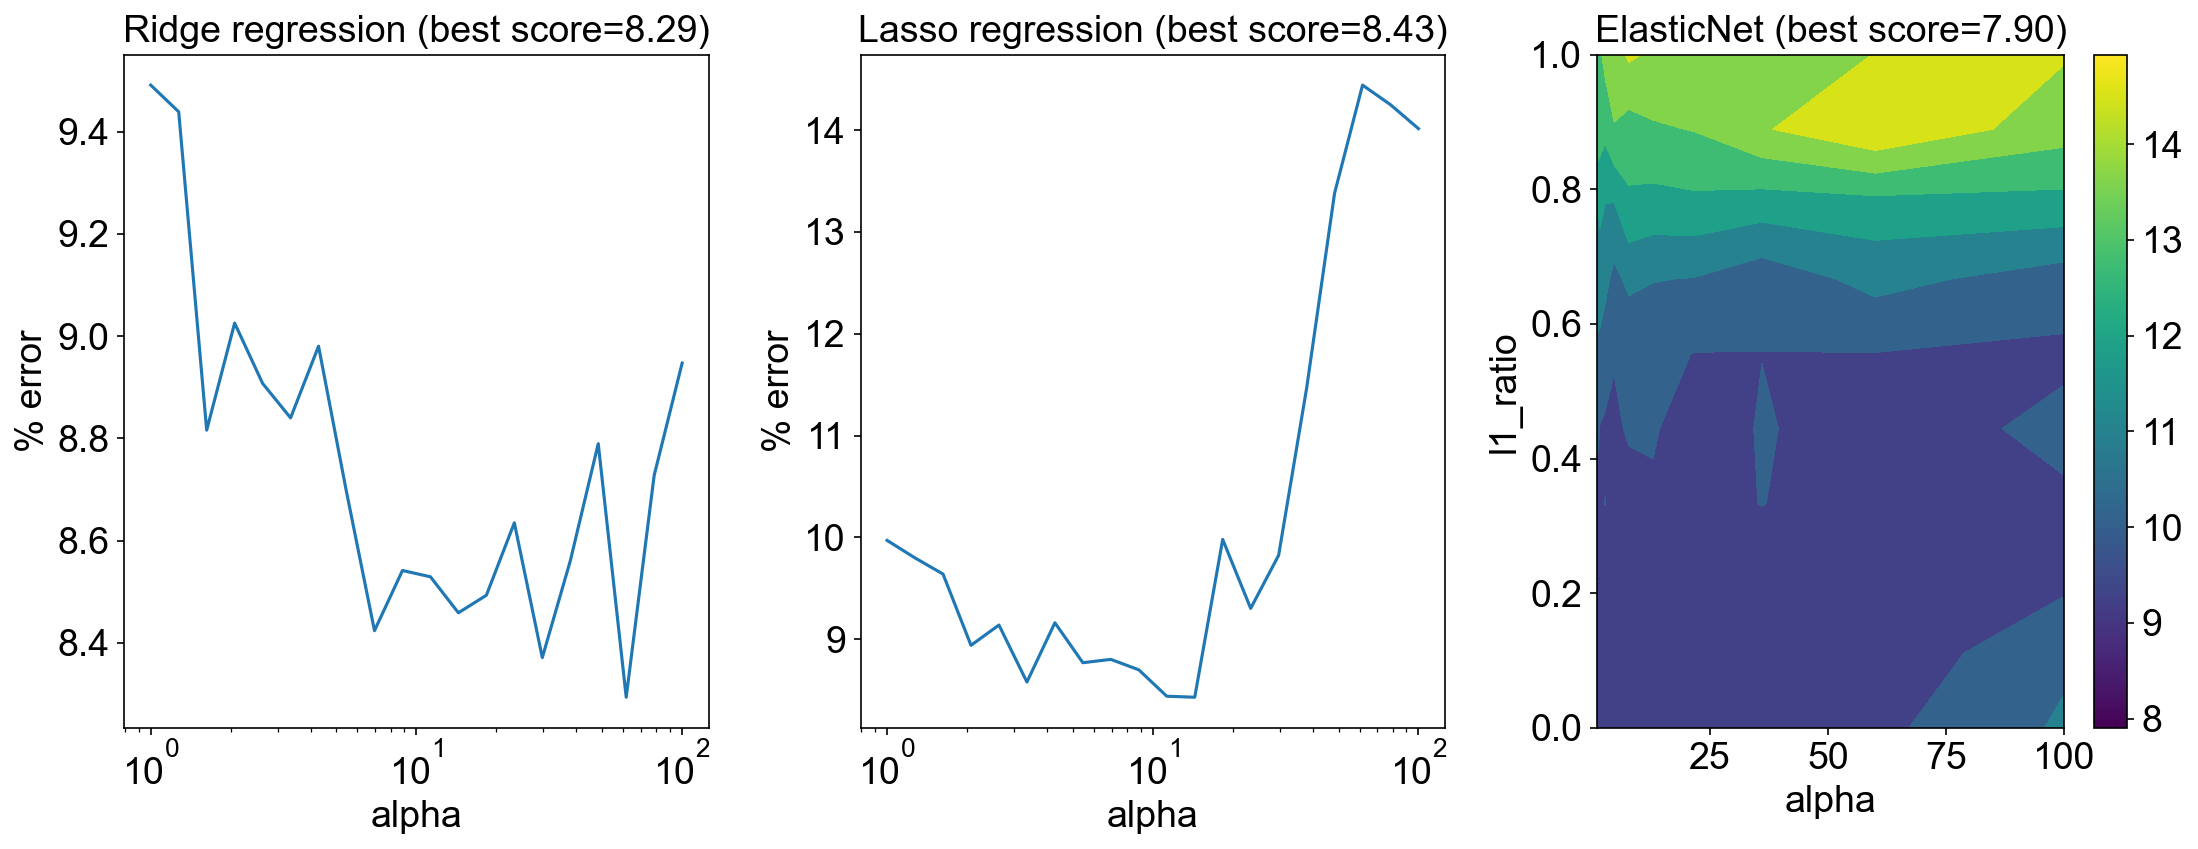

In [33]:
fig = plot_gridsearch(gridsearch_highcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_highcorr.pdf")

0
1
2
3
4
5
6
7
8
9


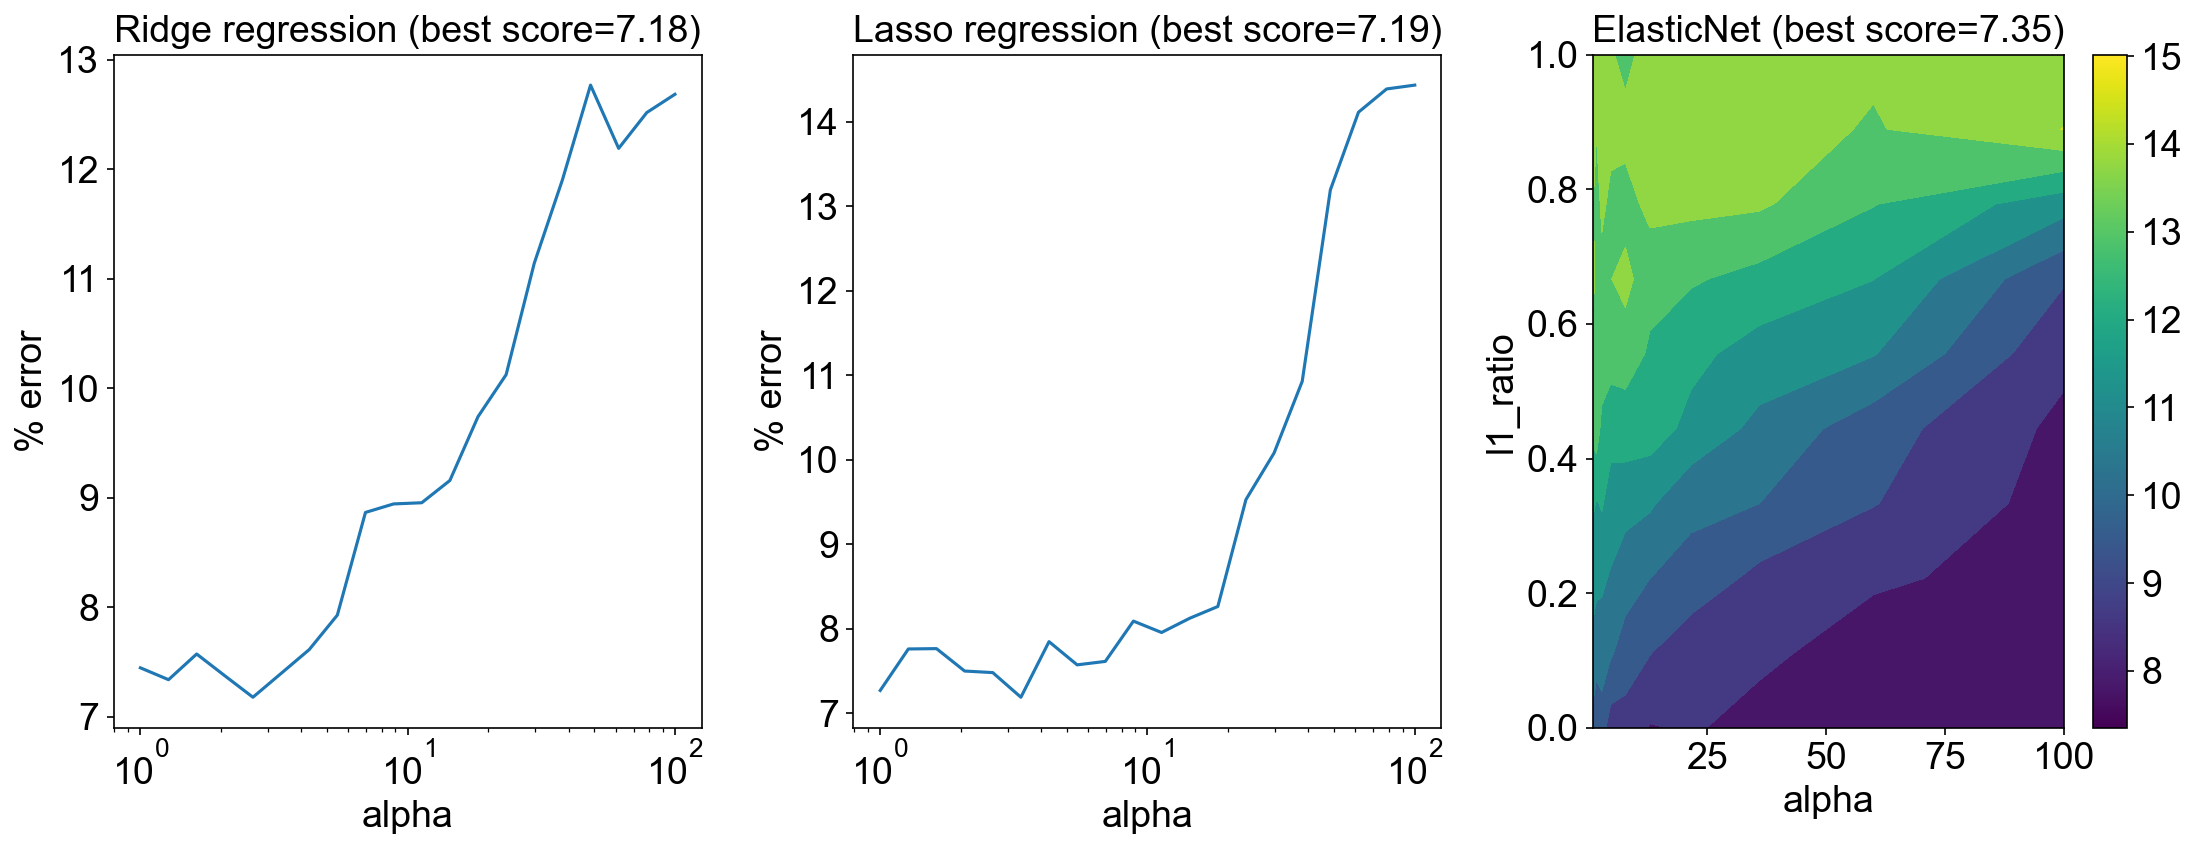

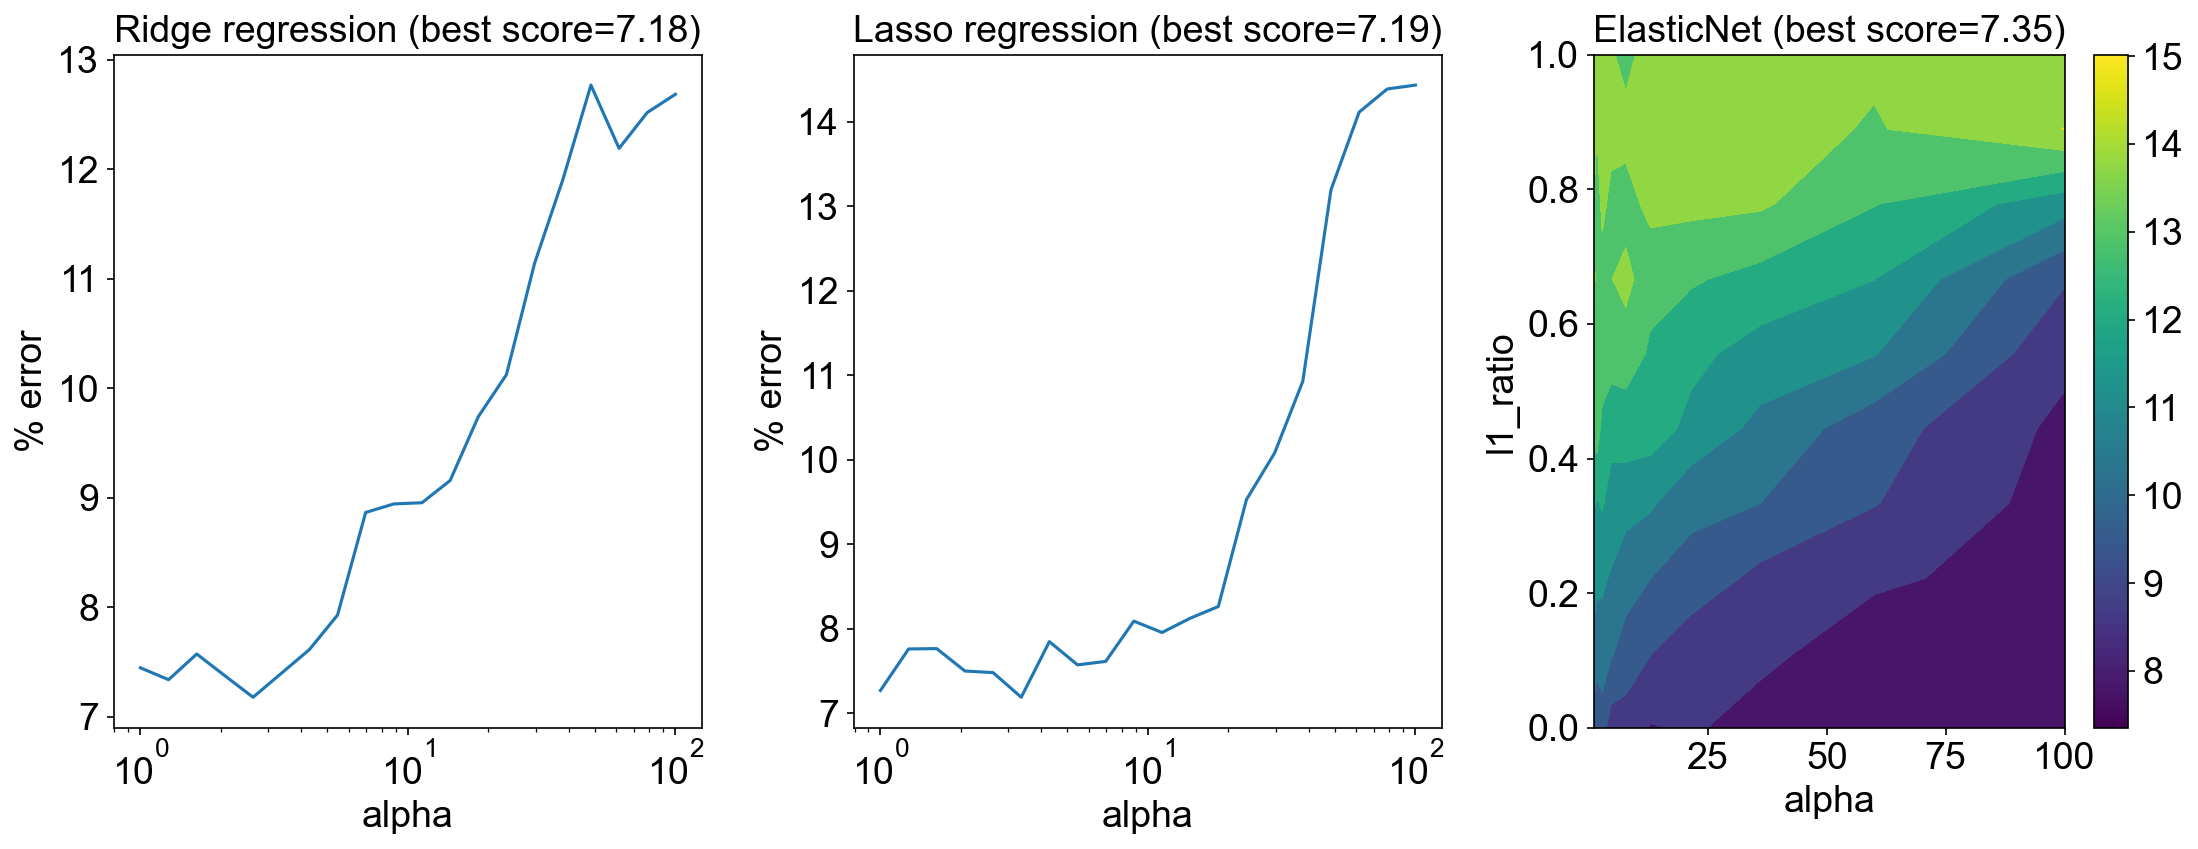

In [34]:
plot_gridsearch(manual_gridsearch("form_first_discharge_capacity_ah", yvar70))

### Manual, very high corr

In [35]:
gridsearch_veryhighcorr = manual_gridsearch(very_high_corr_form_features, yvar70)

0
1
2
3
4
5
6
7
8
9


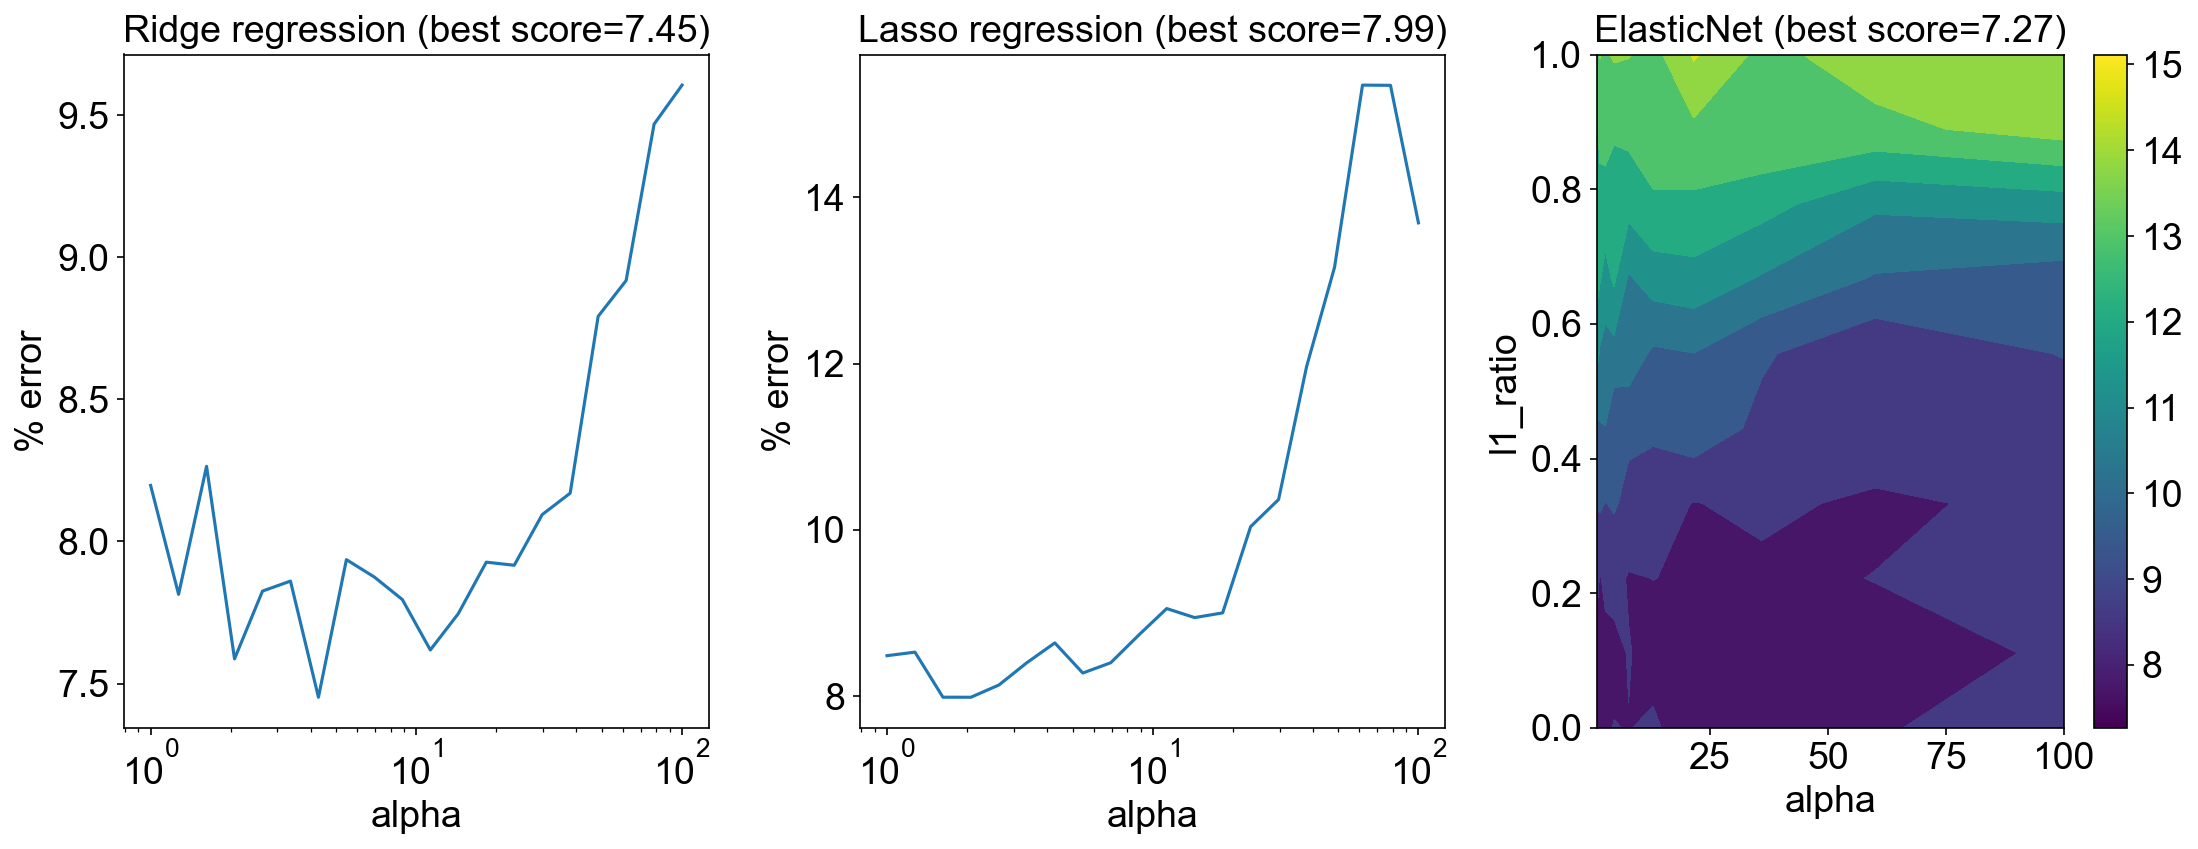

In [36]:
fig = plot_gridsearch(gridsearch_veryhighcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_veryhighcorr.pdf")

In [37]:
yvar

'cycles_to_70_pct'

## Printing lots of models

In [38]:
def print_model(model, yvar, **kwargs):
    print(model)
    print("Label: ", yvar)
    for f in very_high_corr_form_features:
        out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000,
                                  **kwargs)
        print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
    out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000,
                              **kwargs)
    print(f"{'Dummy regressor (predict mean)':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'very high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'all':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    # out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=Lasso(5), num_experiments=1000)
    # print(f"{'Lasso(5), very high corr':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    

In [39]:
print_model(ElasticNet(alpha=50, l1_ratio=0.3), yvar70)

ElasticNet(alpha=50, l1_ratio=0.3)
Label:  cycles_to_70_pct
form_first_discharge_capacity_below_3p2v_ah       7.80 (2.50 std)
form_last_charge_voltage_after_1s                 7.49 (2.56 std)
form_last_charge_voltage_after_60s                7.80 (2.54 std)
form_first_discharge_capacity_ah                  7.39 (2.53 std)
form_first_cycle_efficiency                       7.33 (2.39 std)
form_c20_charge_right_peak_v_per_ah               8.40 (2.59 std)
Dummy regressor (predict mean)          14.22 (4.13 std)
very high corr                          13.02 (3.86 std)
high corr                               11.99 (3.73 std)
all                                     11.86 (3.65 std)


In [40]:
print_model(Ridge(10), yvar50)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.33 (2.50 std)
form_last_charge_voltage_after_1s                 7.13 (2.43 std)
form_last_charge_voltage_after_60s                7.09 (2.33 std)
form_first_discharge_capacity_ah                  7.05 (2.34 std)
form_first_cycle_efficiency                       7.09 (2.33 std)
form_c20_charge_right_peak_v_per_ah               8.01 (2.29 std)
Dummy regressor (predict mean)          12.73 (3.03 std)
very high corr                          7.29 (2.27 std)
high corr                               7.53 (2.37 std)
all                                     8.99 (2.71 std)


In [41]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=False)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.36 (2.57 std)
form_last_charge_voltage_after_1s                 7.31 (2.44 std)
form_last_charge_voltage_after_60s                7.23 (2.29 std)
form_first_discharge_capacity_ah                  7.17 (2.32 std)
form_first_cycle_efficiency                       7.05 (2.43 std)
form_c20_charge_right_peak_v_per_ah               8.06 (2.15 std)
Dummy regressor (predict mean)          12.92 (3.26 std)
very high corr                          7.36 (2.20 std)
high corr                               7.70 (2.38 std)
all                                     9.07 (2.59 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.63 (2.66 std)
form_last_charge_voltage_after_1s                 7.35 (2.52 std)
form_last_charge_voltage_after_60s                7.49 (2.52 std)
form_first_discharge_capacity_ah                  7.41 (2.57 std)
form_first_cycle_efficiency      

In [42]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.20 (2.44 std)
form_last_charge_voltage_after_1s                 7.15 (2.45 std)
form_last_charge_voltage_after_60s                6.93 (2.25 std)
form_first_discharge_capacity_ah                  6.92 (2.38 std)
form_first_cycle_efficiency                       6.90 (2.30 std)
form_c20_charge_right_peak_v_per_ah               7.90 (2.20 std)
Dummy regressor (predict mean)          12.76 (3.08 std)
very high corr                          7.28 (2.22 std)
high corr                               7.48 (2.46 std)
all                                     8.68 (2.54 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.45 (2.54 std)
form_last_charge_voltage_after_1s                 7.38 (2.61 std)
form_last_charge_voltage_after_60s                7.30 (2.51 std)
form_first_discharge_capacity_ah                  7.30 (2.57 std)
form_first_cycle_efficiency      

In [43]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, square=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.51 (2.70 std)
form_last_charge_voltage_after_1s                 7.33 (2.47 std)
form_last_charge_voltage_after_60s                7.27 (2.37 std)
form_first_discharge_capacity_ah                  7.14 (2.44 std)
form_first_cycle_efficiency                       7.24 (2.32 std)
form_c20_charge_right_peak_v_per_ah               8.03 (2.28 std)
Dummy regressor (predict mean)          12.84 (3.20 std)
very high corr                          7.48 (2.36 std)
high corr                               7.83 (2.44 std)
all                                     9.61 (2.93 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.67 (2.69 std)
form_last_charge_voltage_after_1s                 7.48 (2.48 std)
form_last_charge_voltage_after_60s                7.59 (2.56 std)
form_first_discharge_capacity_ah                  7.38 (2.51 std)
form_first_cycle_efficiency      

In [44]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, sqrt=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.11 (2.46 std)
form_last_charge_voltage_after_1s                 7.12 (2.45 std)
form_last_charge_voltage_after_60s                6.99 (2.27 std)
form_first_discharge_capacity_ah                  7.14 (2.41 std)
form_first_cycle_efficiency                       7.22 (2.46 std)
form_c20_charge_right_peak_v_per_ah               7.94 (2.21 std)
Dummy regressor (predict mean)          12.76 (2.98 std)
very high corr                          7.22 (2.35 std)
high corr                               7.72 (2.40 std)
all                                     8.81 (2.54 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.53 (2.53 std)
form_last_charge_voltage_after_1s                 7.40 (2.57 std)
form_last_charge_voltage_after_60s                7.46 (2.52 std)
form_first_discharge_capacity_ah                  7.24 (2.54 std)
form_first_cycle_efficiency      

## PCA

In [45]:
df_form.corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
cycles_to_70_pct                              -0.822596
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
cycles_to_80_pct                              -0.788770
cycles_to_60_pct                              -0.785245
cycles_to_50_pct                              -0.782680
form_6hr_rest_delta_voltage_v_2_to_6_hr       -0.692257
form_6hr_rest_delta_voltage_v_3_to_6_hr       -0.634634
form_6hr_rest_delta_voltage_v_4_to_6_hr       -0.598132
form_6hr_rest_delta_voltage_v_5_to_6_hr       -0

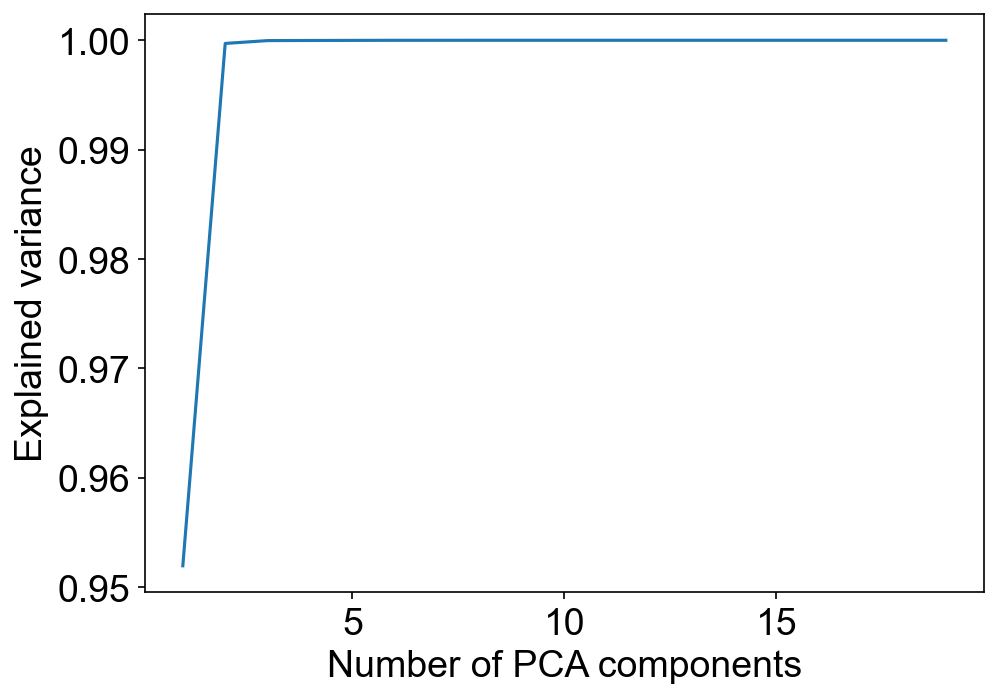

In [46]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_form[form_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots()
ax.plot(range(1,len(cumsum)+1),cumsum)
ax.set_xlabel("Number of PCA components")
ax.set_ylabel("Explained variance")
fig.savefig(OUTPUT_DIR + "pca.pdf")

In [47]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = very_high_corr_form_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

7.384736714503204

## Understanding the model

See https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html 

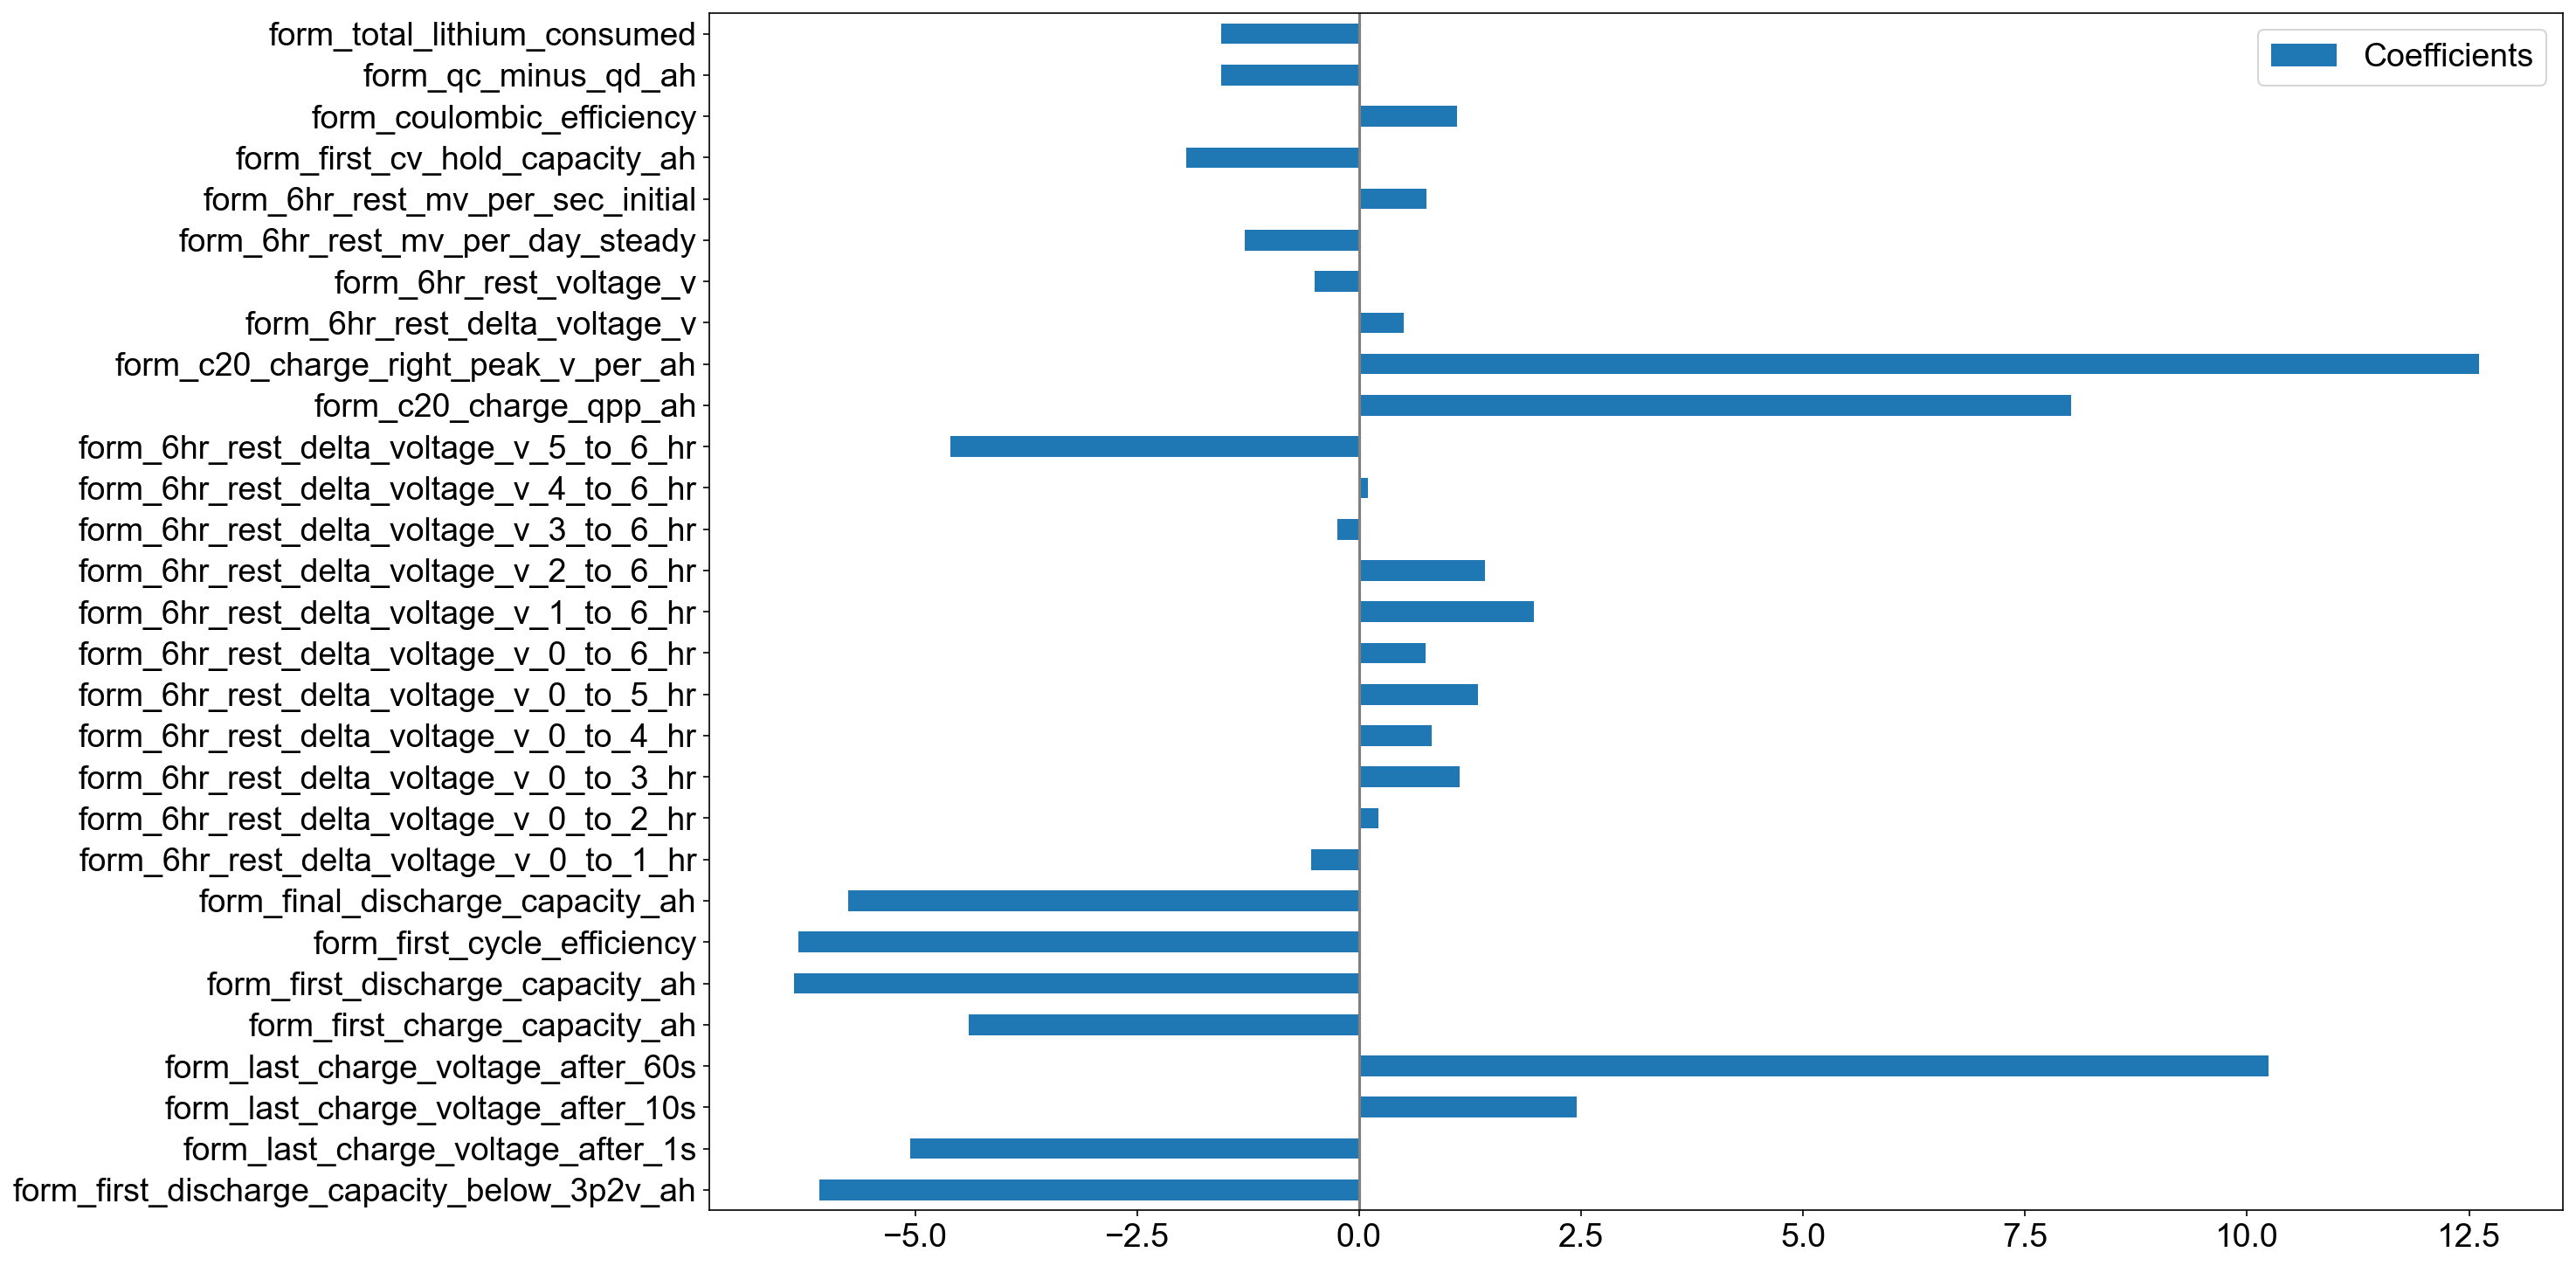

In [48]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(alpha_ridge)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_,
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')

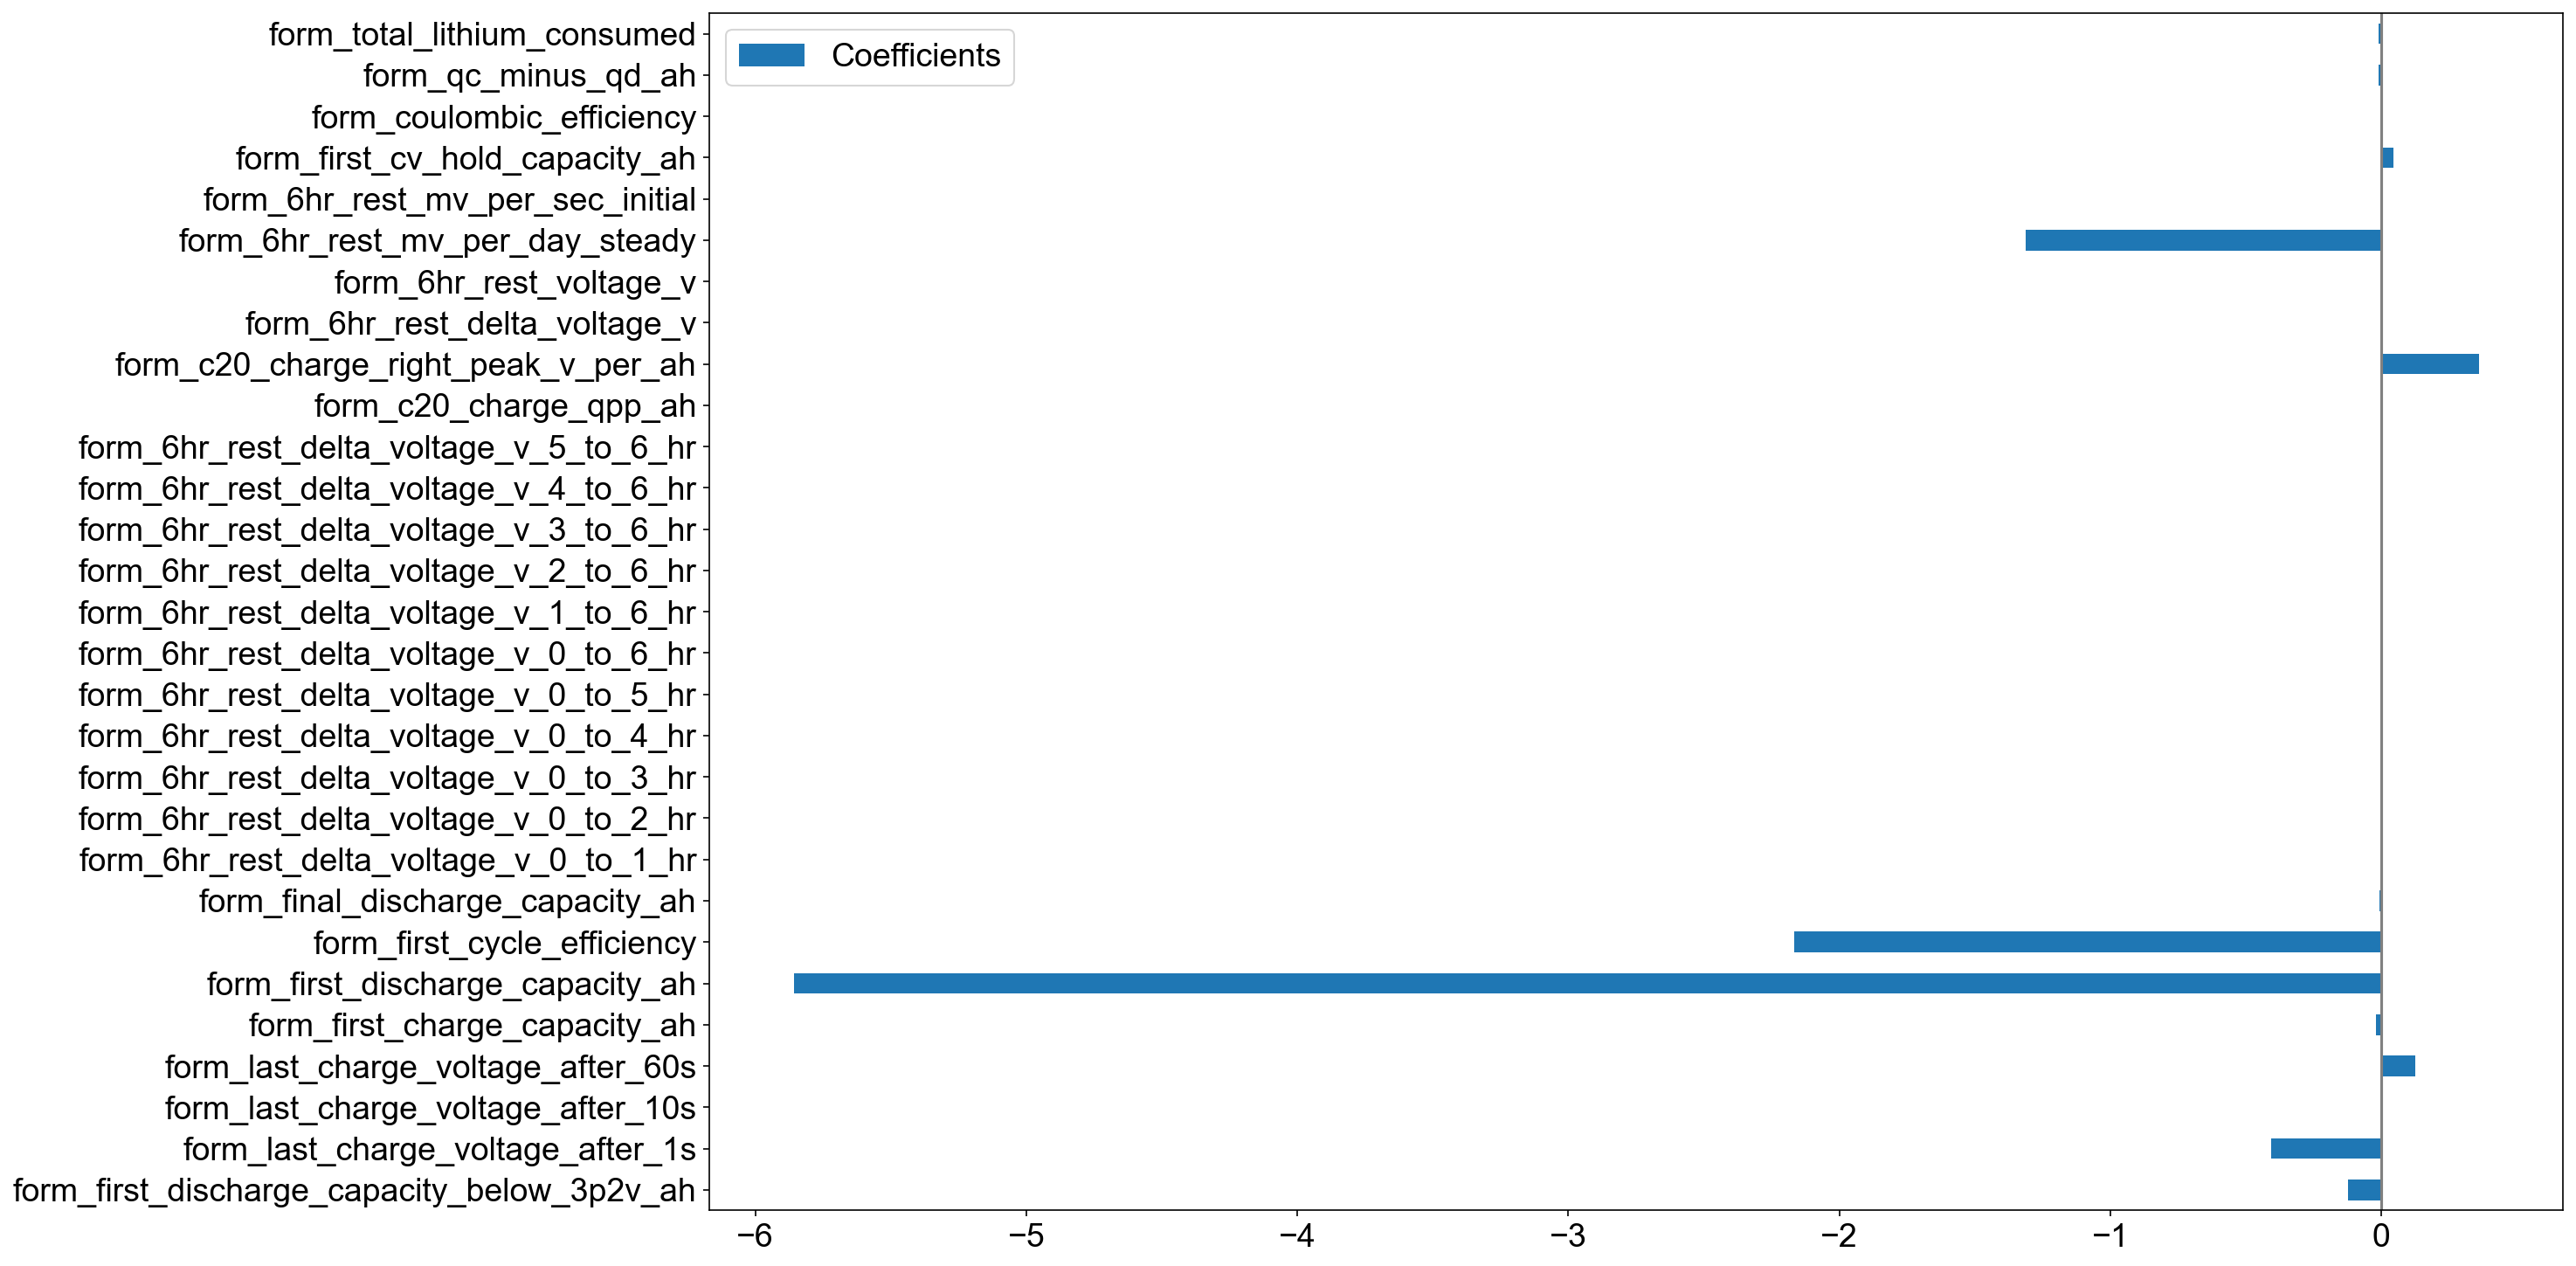

In [49]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(10)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_ * df[form_features].std(axis=0),
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')
plt.savefig(OUTPUT_DIR + "model_coeffs.png")


In [50]:
feat = ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency"]#, "form_6hr_rest_mv_per_day_steady"]
out = train_and_test_model(df, feat, yvar70, to_plot=0, model=Ridge(10), num_experiments=1000, log=True)
print(f"{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

7.85 (2.62 std)


In [51]:
out = train_and_test_model(df, ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency", "form_6hr_rest_mv_per_day_steady"],
                                yvar70, to_plot=0, model=ElasticNet(alpha=0.01,l1_ratio=0.3), num_experiments=1000,
                                  log=True)
print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

form_total_lithium_consumed                       7.81 (2.69 std)


# Including features up to cycle 3

In [52]:
c3_select = lambda x: ((x.endswith("_c3") or x.startswith("esoh_c3_") or x.startswith("rpt_c3_"))
                       and not any(s in x for s in ["LLI", "LAM", "Qcomp", "C20_loss"]))
c3_features = list(filter(c3_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_c3 = df[c3_features + labels]
df_c3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   retention_at_c3        19 non-null     float64
 1   dcr_10s_0_soc_at_c3    19 non-null     float64
 2   dcr_3s_0_soc_at_c3     19 non-null     float64
 3   dcr_1s_0_soc_at_c3     19 non-null     float64
 4   dcr_10s_5_soc_at_c3    19 non-null     float64
 5   dcr_3s_5_soc_at_c3     19 non-null     float64
 6   dcr_1s_5_soc_at_c3     19 non-null     float64
 7   dcr_10s_7_soc_at_c3    19 non-null     float64
 8   dcr_3s_7_soc_at_c3     19 non-null     float64
 9   dcr_1s_7_soc_at_c3     19 non-null     float64
 10  dcr_10s_10_soc_at_c3   19 non-null     float64
 11  dcr_3s_10_soc_at_c3    19 non-null     float64
 12  dcr_1s_10_soc_at_c3    19 non-null     float64
 13  dcr_10s_15_soc_at_c3   19 non-null     float64
 14  dcr_3s_15_soc_at_c3    19 non-null     float64
 15  dcr_1s_1

In [53]:
df_c3.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct       1.000000
cycles_to_60_pct       0.995579
cycles_to_70_pct       0.976940
cycles_to_80_pct       0.971337
esoh_c3_x100           0.812759
                         ...   
dcr_10s_5_soc_at_c3   -0.792791
esoh_c3_neg_excess    -0.829288
esoh_c3_Cn            -0.831686
esoh_c3_np_ratio      -0.845652
esoh_c3_CnCp          -0.845652
Name: cycles_to_50_pct, Length: 54, dtype: float64

In [54]:
for a in np.logspace(-2,2):
    out = train_and_test_model(df, ["esoh_c3_np_ratio"],#,"form_first_discharge_capacity_ah"], 
                               yvar, to_plot=0, model=Ridge(a), num_experiments=1000, log=True)
    print(f"{a:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

0.01                                              8.05 (1.86 std)
0.012067926406393288                              7.93 (1.92 std)
0.014563484775012436                              8.12 (1.92 std)
0.017575106248547922                              7.97 (1.82 std)
0.021209508879201904                              8.03 (1.85 std)
0.025595479226995357                              8.02 (1.78 std)
0.030888435964774818                              8.01 (1.84 std)
0.0372759372031494                                7.98 (1.80 std)
0.04498432668969444                               7.98 (1.80 std)
0.054286754393238594                              8.09 (1.84 std)
0.0655128556859551                                8.11 (1.81 std)
0.07906043210907697                               7.96 (1.84 std)
0.09540954763499938                               8.05 (1.87 std)
0.1151395399326447                                7.99 (1.91 std)
0.13894954943731375                               8.06 (1.88 std)
0.16768329

PCA

In [55]:
pca = PCA()
pca.fit(df[form_features + c3_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(cumsum[:3])
# fig, ax = plt.subplots()
# ax.plot(range(1,len(cumsum)+1),cumsum)
# ax.set_xlabel("Number of PCA components")
# ax.set_ylabel("Explained variance")
# fig.savefig(OUTPUT_DIR + "pca_with_c3.pdf")

[0.8425293  0.99323683 0.99993482]


So now we have two interesting directions

In [56]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = form_features + c3_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

12.461817612342813

# Features for the paper

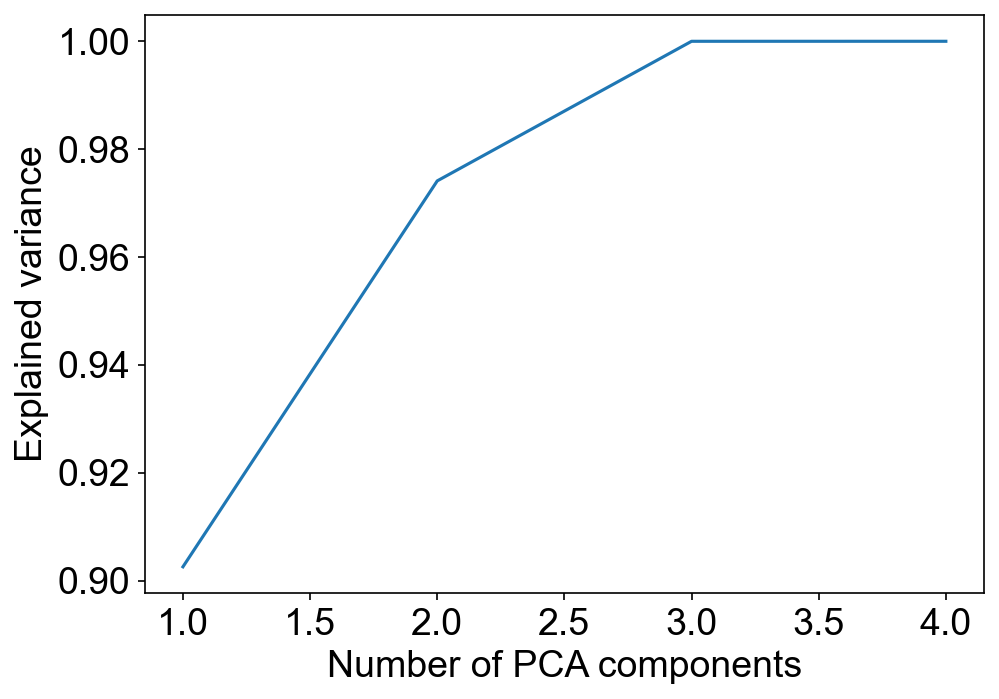

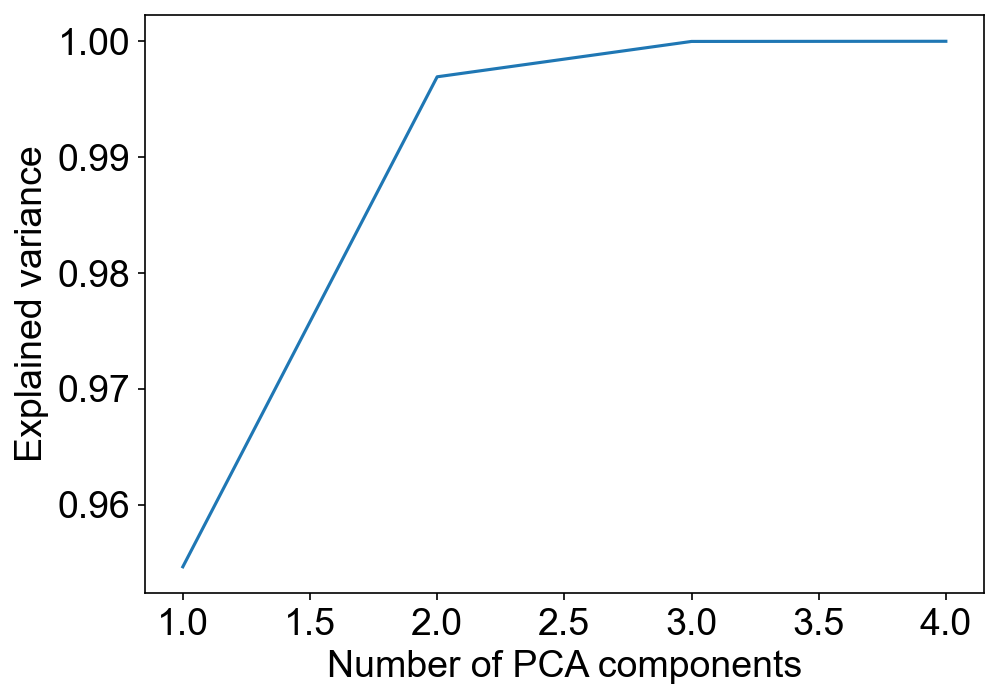

In [57]:
features = [
    "var_q_1c_c100_c10_ah",
    "form_total_lithium_consumed",
    "form_final_discharge_capacity_ah",
    "form_coulombic_efficiency",
    "dcr_10s_5_soc_at_c3",
]
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    pca = PCA()
    pca.fit(df_[features[1:]])
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    fig, ax = plt.subplots()
    ax.plot(range(1,len(cumsum)+1),cumsum)
    ax.set_xlabel("Number of PCA components")
    ax.set_ylabel("Explained variance")
    fig.savefig(OUTPUT_DIR + f"pca_paper_features_{temp}.pdf")

In [58]:
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    print(temp)
    out = train_and_test_model(df_, features[0], yvar70, to_plot=0, model=DummyRegressor(), num_experiments=1000)
    print(f"{'Dummy regressor (predict mean)':<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    for f in features:
        out = train_and_test_model(df_, f, yvar70, to_plot=0, model=LinearRegression(), num_experiments=1000)
        print(f"{f:<50}"
             +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
             +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    f = "form features"
    out = train_and_test_model(df_, features[1:-1], yvar70, to_plot=0, model=Ridge(5), num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    f = "form features + R10s"
    out = train_and_test_model(df_, features[1:], yvar70, to_plot=0, model=Ridge(5), num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

hot
Dummy regressor (predict mean)                    train: 14.11 (0.85 std)		test: 14.73 (3.46 std)
var_q_1c_c100_c10_ah                              train: 10.10 (1.19 std)		test: 11.43 (4.32 std)
form_total_lithium_consumed                       train: 14.00 (0.97 std)		test: 15.97 (3.86 std)
form_final_discharge_capacity_ah                  train: 13.11 (0.87 std)		test: 14.55 (3.71 std)
form_coulombic_efficiency                         train: 13.98 (0.97 std)		test: 15.77 (3.70 std)
dcr_10s_5_soc_at_c3                               train: 6.40 (0.65 std)		test: 7.38 (2.63 std)
form features                                     train: 12.86 (0.93 std)		test: 15.06 (4.03 std)
form features + R10s                              train: 6.79 (0.50 std)		test: 8.45 (2.28 std)
room
Dummy regressor (predict mean)                    train: 13.28 (0.99 std)		test: 14.46 (4.07 std)
var_q_1c_c100_c10_ah                              train: 11.02 (1.38 std)		test: 12.81 (4.33 std)
form_total_lith